In [1]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
# Import libraries
from scipy.ndimage import affine_transform, map_coordinates, rotate
from scipy.cluster.hierarchy import dendrogram, linkage
from nptyping import NDArray, Shape, Int, Int64, Float64
from scipy.fftpack import ifftshift, fft2, ifft2
from typing import List, Any, Tuple, Dict, Set
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from dataclasses import dataclass
from scipy.ndimage import shift
import matplotlib.pyplot as plt
from functools import partial
from numpy import cos, sin
from scipy import optimize
import matplotlib.cm as cm
from typing import Tuple
import multiprocessing
from enum import Enum
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import logging
import mrcfile
import pickle
import numba
import math
import tqdm
import sys
import os
# Import Python scripts
from params import p
from FindCCGraph import op as FindCCGraph
project_name = "sample"

In [2]:
def distribute3Sphere(numPts: int):
    """
    Distributes points roughly uniformly on a unit 3-sphere.

    Parameters:
    - numPts (int): The number of points to distribute on the 3-sphere.

    Returns:
    - tuple: A tuple containing:
        - results (np.ndarray): An array of shape (numPts, 3) containing the coordinates
          of the points distributed on the 3-sphere.
        - it (int): The number of iterations the algorithm performed.

    Notes:
    - The algorithm aims for a uniform distribution by adjusting the spacing between points
      based on the surface area of a unit 3-sphere and the desired number of points.
    - It iteratively adjusts the spacing (delta) to approach the target number of points,
      recalculating the distribution in each iteration until the desired number is reached
      or the maximum number of iterations (maxIter) is exceeded.
    - The algorithm may produce slightly more or fewer points than requested due to the
      discretization process. The final number of points returned matches `numPts`.
    - This method is useful for generating points for applications requiring uniform
      coverage of a spherical surface, such as sampling, simulations, or geometric analyses.
    """
    maxIter = 100  # Maximum number of iterations to attempt
    K = numPts
    A3 = 4 * np.pi  # Surface area of a unit 3-sphere
    delta = np.exp(np.log(A3 / K) / 2.)  # Initial spacing between points
    results = np.zeros((2 * K, 3))  # Allocate space for up to twice the requested points
    it = 0  # Iteration counter
    id = 0  # Point counter

    while id != K and it < maxIter:
        it += 1
        id = 0
        dw1 = delta
        for w1 in np.arange(0.5 * dw1, np.pi, dw1):
            cw1 = np.cos(w1)
            sw1 = np.sin(w1)
            x1 = cw1
            dw2 = dw1 / sw1  # Adjust spacing for the next dimension
            for w2 in np.arange(0.5 * dw2, 2 * np.pi, dw2):
                cw2 = np.cos(w2)
                sw2 = np.sin(w2)
                x2 = sw1 * cw2
                x3 = sw1 * sw2
                if id < 2 * K:  # Prevent index out of bounds
                    results[id, :] = np.hstack((x1, x2, x3))
                    id += 1
        delta = delta * np.exp(np.log(float(id) / K) / 2.)  # Adjust spacing based on current point count

    results = results[0:K, :]  # Trim or expand the results to the requested number of points
    return (results, it)

In [3]:
def quaternion_to_S2(q):
    """
    Converts a set of quaternions to points on the 2-sphere (S2) in three-dimensional space.

    This function transforms quaternions, representing rotations in 3D space, into coordinates
    on a unit sphere. It effectively captures the orientation encoded by the quaternion while
    disregarding the rotation around the final axis (psi rotation), simplifying the representation
    of orientation.

    Parameters:
    - q (np.ndarray): A 4xN numpy array where each column represents a quaternion. The quaternion
      is expected to be in the form [q0, q1, q2, q3] with q0 as the real part and q1, q2, q3 as
      the imaginary parts.

    Returns:
    - np.ndarray: A 3xN numpy array where each column represents the 3D coordinates [x, y, z] of
      a point on the unit sphere (S2). These coordinates correspond to the orientation represented
      by the input quaternions.

    Notes:
    - The conversion formula used in this function maps the quaternion's rotation to a point on
      the sphere by selecting specific combinations of the quaternion components. This mapping
      focuses on the spatial orientation and ignores the final rotation around the axis, which
      is not represented on the 2-sphere.
    - The function is useful in contexts where the orientation needs to be visualized or analyzed
      without the complexity of handling full quaternion rotations, such as in computer graphics,
      robotics, and orientation tracking.
    """
    # Calculate the 3D coordinates on the unit sphere from the quaternion components
    S2 = 2*np.vstack((q[1, :]*q[3, :] - q[0, :]*q[2, :],
                      q[0, :]*q[1, :] + q[2, :]*q[3, :],
                      q[0, :]**2 + q[3, :]**2 - 0.5))
    return S2

In [4]:
def collect_nearest_neighbors(X, Q):
    """
    Finds the nearest neighbors of a set of query points Q within a dataset X and counts
    the occurrences of each point in X being the nearest neighbor.

    Parameters:
    - X (np.ndarray): An array of shape (n_samples, n_features) representing the dataset
      within which to search for nearest neighbors. Each row corresponds to a data point.
    - Q (np.ndarray): An array of shape (n_queries, n_features) representing the query
      points for which the nearest neighbors in X are to be found. Each row corresponds
      to a query point.

    Returns:
    - tuple: A tuple containing:
        - neighb_bins (np.ndarray): An array of indices of the nearest neighbors in X for
          each query point in Q. Shape is (n_queries, 1).
        - bin_counts (np.ndarray): An array of counts indicating how many times each point
          in X is the nearest neighbor to the points in Q. Shape is (n_samples,).

    Notes:
    - The function uses the 'ball_tree' algorithm for efficient nearest neighbor search,
      which is particularly suitable for datasets with a large number of samples and/or
      high dimensionality.
    - The `NearestNeighbors` class from scikit-learn is used to fit the model on dataset X
      and then query the nearest neighbors for points in Q.
    - The `bin_counts` array provides a histogram-like count of nearest neighbor occurrences,
      which can be useful for understanding the density or distribution of query points around
      the dataset X.
    """
    nbins = X.shape[0]  # Number of bins is equal to the number of samples in X
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)  # Fit the model on X
    neighb_bins = nbrs.kneighbors(Q, return_distance=False)  # Find nearest neighbors for Q in X
    bin_counts = np.bincount(neighb_bins.squeeze(), minlength=nbins)  # Count occurrences
    return neighb_bins, bin_counts

In [5]:
def bin_and_threshold(q, bin_width, thres_low, thres_high):
    """
    Bins quaternions onto a unit sphere and identifies bins based on threshold criteria.

    Parameters:
    - q (np.ndarray): An array of quaternions to be processed. Expected shape is (4, N),
      where N is the number of quaternions.
    - bin_width (float): The approximate width of each bin on the sphere, used to calculate
      the number of bins based on the surface area of the unit sphere.
    - thres_low (int): The lower threshold for the number of points in a bin to be considered
      significant.
    - thres_high (int): The upper threshold for filtering bins (not directly used in this
      function but included for completeness and potential extension).

    Returns:
    - tuple: A tuple containing:
        - neighb_list (np.ndarray): An array of lists, where each list contains indices of
          points in S2 that fall into the corresponding bin.
        - S2 (np.ndarray): The coordinates of points on the unit sphere (S2) obtained from
          the input quaternions.
        - bin_centers (np.ndarray): The coordinates of the centers of the bins on S2.
        - n_points_in_bin (np.ndarray): The number of points in each bin.
        - conjugate_bins (list): Indices of bins that have more than `thres_low` points and
          are in the bigger half of the bin list.

    Notes:
    - The function first calculates the number of bins based on the specified `bin_width` and
      uses the `distribute3Sphere` function to determine the centers of these bins on the unit
      sphere.
    - It then maps the input quaternions onto the unit sphere (S2) using the `quaternion_to_S2`
      function.
    - The `collect_nearest_neighbors` function is used to assign each point on S2 to the nearest
      bin and count the number of points in each bin.
    - Bins are filtered based on the `thres_low` criterion and their position in the bin list to
      identify `conjugate_bins` that meet the specified conditions.
    - The `thres_high` parameter is included for potential use in extending the function's
      functionality but is not used in the current implementation.
    """
    # Attempt to bin sphere in equal patches with area ~bin_width^2
    requested_n_bins = int(4 * np.pi / (bin_width**2))
    bin_centers = distribute3Sphere(requested_n_bins)[0].T
    n_bins = bin_centers.shape[1]

    # Map quaternions onto unit_vectors (S2)
    S2 = quaternion_to_S2(q)

    # For each point in S2, find closest bin
    neighb_bins, n_points_in_bin = collect_nearest_neighbors(bin_centers.T, S2.T)

    # For each bin, list all points in S2 that live in that bin
    neighb_list = [[] for _ in range(n_bins)]
    for i, index in enumerate(neighb_bins.ravel()):
        neighb_list[index].append(i)
    neighb_list = np.array([np.array(a) for a in neighb_list], dtype=object)

    # List bins that have more than thres_low points and lie on bigger half of bin list
    conjugate_bins = []
    start_bin, end_bin = (n_bins // 2, n_bins) if n_bins % 2 else (0, n_bins // 2)
    for pd_rel, n_points in enumerate(n_points_in_bin[start_bin:end_bin]):
        if n_points >= thres_low:
            conjugate_bins.append(pd_rel + start_bin)

    return (neighb_list, S2, bin_centers, n_points_in_bin, conjugate_bins)

In [6]:
def q_product(q, s):
    """
    Calculates the quaternion product of two quaternions or arrays of quaternions.

    Parameters:
    - q (np.ndarray): A 4xN or 4x1 numpy array representing the first quaternion(s),
      where N is the number of quaternions.
    - s (np.ndarray): A 4xN or 4x1 numpy array representing the second quaternion(s),
      matching the dimensions of q.

    Returns:
    - np.ndarray: The quaternion product, in the same format as the inputs (4xN or 4x1).

    Notes:
    - Quaternions are represented as [q0, q1, q2, q3], where q0 is the scalar part,
      and [q1, q2, q3] represent the vector part.
    - The function supports broadcasting, allowing for the multiplication of a single
      quaternion with an array of quaternions and vice versa.
    - Quaternion multiplication is not commutative; the order of operands affects the result.
    - This function reshapes 1-dimensional input arrays to 2D for consistent processing
      and uses assertions to ensure proper input dimensions.
    """
    # Ensure inputs are 2-dimensional
    if len(q.shape) < 2:
        q = q.reshape(-1, 1)
    if len(s.shape) < 2:
        s = s.reshape(-1, 1)

    # Check that both quaternions have 4 elements
    try:
        assert (q.shape[0] > 3 and s.shape[0] > 3)
    except AssertionError:
        print('subroutine qMult_bsx: some vector have less than 4 elements')

    # Decompose quaternions into scalar and vector parts
    q0 = q[0, :]
    qv = q[1:4, :]
    s0 = s[0, :]
    sv = s[1:4, :]

    # Compute the vector cross product and the quaternion product
    c = np.vstack((qv[1, :] * sv[2, :] - qv[2, :] * sv[1, :],
                   qv[2, :] * sv[0, :] - qv[0, :] * sv[2, :],
                   qv[0, :] * sv[1, :] - qv[1, :] * sv[0, :]))

    # Calculate the final quaternion product
    p = np.vstack((q0 * s0 - np.sum(qv * sv, axis=0), q0 * sv + s0 * qv + c))
    return p

In [7]:
def eul_to_quat(phi, theta, psi, flip=True):
    """
    Converts Euler angles to quaternions.

    Parameters:
    - phi (np.ndarray): Array of rotations around the z-axis.
    - theta (np.ndarray): Array of rotations around the y-axis.
    - psi (np.ndarray): Array of rotations around the x-axis.
    - flip (bool, optional): If True, flips the sign of the psi component. Defaults to True.

    Returns:
    - np.ndarray: An array of quaternions representing the rotations. Each quaternion is
      represented as a column in a 4xN array, where N is the number of sets of Euler angles.

    Notes:
    - The function constructs individual quaternions for rotations around the z, y, and x axes
      (qz, qy, qzs respectively) and then combines them through quaternion multiplication to
      obtain the final quaternion representing the combined rotation.
    - The `flip` parameter can be used to adjust for different conventions in the definition
      of rotations.
    """
    # Initialize a zero array for non-rotational components
    zros = np.zeros(phi.shape[0])
    
    # Construct quaternions for rotations around z, y, and (optionally flipped) x axes
    qz = np.vstack((np.cos(phi / 2), zros, zros, -np.sin(phi / 2)))
    qy = np.vstack((np.cos(theta / 2), zros, -np.sin(theta / 2), zros))
    sp = -np.sin(psi / 2) if flip else np.sin(psi / 2)
    qzs = np.vstack((np.cos(psi / 2), zros, zros, sp))
    
    # Combine the rotations through quaternion multiplication
    q = q_product(qzs, q_product(qy, qz))
    
    return q

In [8]:
def parse_star(starfile, skip, keep_index=False):
    """
    Parses a STAR file and returns the data as a pandas DataFrame.

    Parameters:
    - starfile (str): The path to the STAR file to be parsed.
    - skip (int): The number of lines to skip at the beginning of the file before starting
      to look for headers. This is useful for skipping comments or metadata at the top of the file.
    - keep_index (bool, optional): If True, keeps the original index (column number) in the header
      names. Defaults to False.

    Returns:
    - pd.DataFrame: A pandas DataFrame containing the data from the STAR file, with columns
      named according to the headers found in the file.

    Notes:
    - The function first scans the file to find headers (lines starting with "_rln"). It records
      these headers and determines where the data section starts.
    - If `keep_index` is False, the function strips the leading "_rln" and trailing index number
      from the header names, leaving a more readable column name.
    - After identifying the headers and the start of the data section, the function reads the
      data into a pandas DataFrame, using the headers as column names.
    - This function is specifically tailored for STAR files used in cryo-EM data processing and
      may not be suitable for STAR files with a significantly different format.
    """
    headers = []  # List to store header names
    foundheader = False  # Flag to indicate when headers start
    ln = 0  # Line number counter

    # Open the STAR file and scan for headers
    with open(starfile, 'rU') as f:
        for l in f:
            if ln < skip:
                ln += 1
                continue
            if l.startswith("_rln"):
                foundheader = True
                if keep_index:
                    head = l.rstrip()
                else:
                    head = l.split('#')[0].rstrip().lstrip('_')
                headers.append(head)
            else:
                if foundheader:
                    break  # Stop scanning once headers are found and data section begins
            ln += 1

    # Read the data section into a pandas DataFrame
    star = pd.read_table(starfile, skiprows=ln, delimiter='\s+', header=None)
    star.columns = headers  # Assign column names based on headers

    return star

In [9]:
def parse_star_optics(starfile, keep_index=False):
    """
    Parses the optics section of a STAR file and returns the data as a pandas DataFrame.

    Parameters:
    - starfile (str): The path to the STAR file to be parsed.
    - keep_index (bool, optional): If True, keeps the original index (column number) in the header
      names. Defaults to False.

    Returns:
    - tuple: A tuple containing:
        - pd.DataFrame: A pandas DataFrame containing the first row of data from the optics section
          of the STAR file, with columns named according to the headers found in the file.
        - int: The line number where the data section ends, useful for further parsing.

    Notes:
    - The function scans the file for headers starting with "_rln". These headers define the columns
      of the optics section.
    - If `keep_index` is False, the function cleans the header names by removing the leading "_rln"
      and any trailing index number, making the column names more readable.
    - The function reads only the first row of data under the headers into a DataFrame, assuming
      that the optics section contains a single set of parameters.
    - This function is useful for extracting optics-related metadata from STAR files used in
      cryo-EM data processing.
    """
    headers = []  # List to store header names
    foundheader = False  # Flag to indicate when headers start
    ln = 0  # Line number counter

    # Open the STAR file and scan for headers
    with open(starfile, 'r') as f:  # Adjusted for Python 3 compatibility
        for l in f:
            if l.startswith("_rln"):
                foundheader = True
                if keep_index:
                    head = l.rstrip()
                else:
                    head = l.split('#')[0].rstrip().lstrip('_')
                headers.append(head)
            else:
                if foundheader:
                    break  # Stop scanning once headers are found and data section begins

    # Read the first row of data into a pandas DataFrame
    star = pd.read_table(starfile, skiprows=ln, delimiter='\s+', header=None, nrows=1)
    star.columns = headers  # Assign column names based on headers

    return (star, ln + 1)

In [10]:
def get_align_data(align_star_file, flip):
    """
    Extracts alignment data and microscope parameters from a RELION STAR file.

    Parameters:
    - align_star_file (str): Path to the STAR file containing alignment and microscope parameters.
    - flip (bool): Indicates whether to flip the sign of the psi component when converting
      Euler angles to quaternions.

    Returns:
    - tuple: A tuple containing:
        - sh (tuple): A tuple of numpy arrays (shx, shy) representing the shifts in X and Y.
        - q (np.ndarray): A numpy array of quaternions representing the rotations.
        - U (np.ndarray): A numpy array containing the defocus U values.
        - V (np.ndarray): A numpy array containing the defocus V values.

    Notes:
    - The function first checks if the STAR file is in the old or new RELION format by looking
      for the "data_optics" section.
    - It then parses the optics and particles sections accordingly using `parse_star` and
      `parse_star_optics` functions to extract the required data.
    - Microscope parameters such as voltage, spherical aberration, and amplitude contrast are
      extracted from the optics section.
    - Alignment parameters including defocus values, shifts, and Euler angles are extracted from
      the particles section.
    - Shifts are adjusted based on available columns and pixel size, and Euler angles are
      converted to quaternions.
    - The function is designed to work with RELION STAR files and may need adjustments for
      compatibility with other formats or versions.
    """
    relion_old = True
    with open(align_star_file, 'r') as f:
        for line in f:
            if line.startswith("data_optics"):
                relion_old = False
                break

    if relion_old:
        skip = 0
        df = parse_star(align_star_file, skip, keep_index=False)
        df0 = df
    else:
        print('RELION Optics Group found.')
        df0, skip = parse_star_optics(align_star_file, keep_index=False)
        df = parse_star(align_star_file, skip, keep_index=False)

    try:
        p.EkV = float(df0['rlnVoltage'].values[0])
        p.Cs = float(df0['rlnSphericalAberration'].values[0])
        p.AmpContrast = float(df0['rlnAmplitudeContrast'].values[0])
    except:
        print('missing microscope parameters')
        exit(1)

    try:
        U = df['rlnDefocusU'].values
        V = df['rlnDefocusV'].values
    except:
        print("missing defocus")
        exit(1)

    # Handling shifts
    if 'rlnOriginX' in df.columns and 'rlnOriginY' in df.columns:
        shx = df['rlnOriginX'].values
        shy = df['rlnOriginY'].values
    elif 'rlnOriginXAngst' in df.columns and 'rlnOriginYAngst' in df.columns:
        shx = df['rlnOriginXAngst'].values / p.pix_size
        shy = df['rlnOriginYAngst'].values / p.pix_size
    else:
        print(f"Warning: missing relion origin data in {align_star_file}")
        shx = U * 0.
        shy = shx
    sh = (shx, shy)

    # Handling Euler angles and converting to quaternions
    try:
        phi = np.deg2rad(df['rlnAngleRot'].values)
        theta = np.deg2rad(df['rlnAngleTilt'].values)
        psi = np.deg2rad(df['rlnAnglePsi'].values)
    except:
        print("missing Euler angles")
        exit(1)
    q = eul_to_quat(phi, theta, psi, flip)

    return (sh, q, U, V)

In [11]:
# Initialize a logger for error reporting
_logger = logging.getLogger(__name__)
_logger.setLevel(logging.DEBUG)

def augment(q):
    """
    Augments a set of quaternions by adding their conjugates to the set.

    Parameters:
    - q (np.ndarray): A numpy array of shape (4, N) representing a set of quaternions,
      where N is the number of quaternions.

    Returns:
    - np.ndarray: An augmented numpy array of shape (4, 2N) containing the original
      set of quaternions followed by their conjugates.

    Raises:
    - AssertionError: If the input array does not have the correct shape (i.e., does not
      have 4 rows representing quaternions).

    Notes:
    - The conjugate of a quaternion [q0, q1, q2, q3] is defined as [q0, -q1, -q2, -q3].
    - This function is useful for operations that require both a quaternion and its inverse,
      such as applying rotations and their reversals.
    """
    try:
        assert (q.shape[0] == 4)  # Ensure the input array represents quaternions
    except AssertionError:
        _logger.error('subroutine augment: q has wrong dimensions')
        _logger.exception('subroutine augment: q has wrong dimensions')
        raise  # Reraise the exception to ensure it's caught by calling code

    # Calculate the conjugate of each quaternion
    qc = np.vstack((-q[1, :], q[0, :], -q[3, :], q[2, :]))

    # Augment the original set with the conjugates
    q = np.hstack((q, qc))

    return q

In [12]:
# data_store

In [13]:
class Sense(Enum):
    """
    An enumeration to represent the direction of projection or alignment.
    
    Attributes:
    - FWD (int): Represents the forward direction.
    - REV (int): Represents the reverse direction.
    
    Methods:
    - from_index(idx: int) -> 'Sense': Converts an integer index to a Sense enum.
    - to_index(self) -> int: Converts the Sense enum to an integer index.
    """
    FWD = 1
    REV = -1

    @staticmethod
    def from_index(idx: int) -> 'Sense':
        """
        Converts an integer index to a Sense enum.
        
        Parameters:
        - idx (int): The index to convert.
        
        Returns:
        - Sense: The corresponding Sense enum value.
        
        Raises:
        - ValueError: If the index is invalid.
        """
        if idx == 0:
            return Sense.FWD
        if idx == 1:
            return Sense.REV
        raise ValueError("Invalid index")

    def to_index(self) -> int:
        """
        Converts the Sense enum to an integer index.
        
        Returns:
        - int: The corresponding index value.
        """
        return 0 if self == Sense.FWD else 1

class Anchor:
    """
    Represents an anchor point with associated properties.
    
    Parameters:
    - CC (int): Cross-correlation coefficient, defaulting to 1.
    - sense (Sense): The direction of the projection, defaulting to Sense.FWD.
    
    Attributes:
    - CC (int): Stores the cross-correlation coefficient.
    - sense (Sense): Stores the direction of the projection.
    """
    def __init__(self, CC: int = 1, sense: Sense = Sense.FWD):
        self.CC: int = CC
        self.sense: Sense = sense

class _ProjectionDirections:
    """
    Manages and processes projection direction data, including thresholds, bin centers, defocus values, and more.
    
    Attributes:
    - Various attributes to store thresholds, bin centers, defocus values, microscope origins, full position data,
      quaternion data, image indices, threshold IDs, occupancy data, anchor points, and neighbor graph data.
    
    Methods:
    - load(pd_file=None): Loads projection direction data from a file.
    - save(): Saves the current projection direction data to a file.
    - update(): Updates the projection direction data based on external parameters or files.
    - insert_anchor(id: int, anchor: Anchor): Inserts an anchor point into the dataset.
    - remove_anchor(id: int): Removes an anchor point from the dataset.
    - deduplicate(arr): Removes duplicate entries from an array.
    
    Properties:
    - Provides access to various subsets or transformations of the data, such as occupancy without duplication,
      bin centers without duplication, anchor IDs, thresholded image indices, occupancy for thresholded IDs,
      the number of bins, and the number of thresholded entries.
    """
    def __init__(self):
        # Initialize attributes with default values or empty structures
        self.thres_low: int = p.PDsizeThL
        self.thres_high: int = p.PDsizeThH
        self.bin_centers: NDArray[Shape["3,*", Any], Float64] = np.empty(shape=(3, 0))
        self.defocus: NDArray[Shape["*"], Float64] = np.empty(0)
        self.microscope_origin: Tuple[NDArray[Shape["*"], Float64], NDArray[Shape["*"], Float64]] = (np.empty(0), np.empty(0))
        self.pos_full: NDArray[Shape["3", Any], Float64] = np.empty(shape=(3,0))
        self.quats_full: NDArray[Shape["4", Any], Float64] = np.empty(shape=(4,0))
        self.image_indices_full: NDArray[Shape["*"], List[Int]] = np.empty(0, dtype=object)
        self.thres_ids: NDArray[Shape["*"], Int64] = np.empty(0, dtype=np.int64)
        self.occupancy_full: NDArray[Shape["*"], Int] = np.empty(0, dtype=int)
        self.anchors: Dict[int, Anchor] = {}
        self.trash_ids: Set[int] = set()
        self.reembed_ids: Set[int] = set()
        self.neighbor_graph: Dict[str, Any] = {}
        self.neighbor_subgraph: List[Dict[str, Any]] = []
        self.neighbor_graph_pruned: Dict[str, Any] = {}
        self.neighbor_subgraph_pruned: List[Dict[str, Any]] = []
        self.pos_thresholded: NDArray[Shape["3", Any], Float64] = np.empty(shape=(3,0))
        self.theta_thresholded: NDArray[Shape["*"], Float64] = np.empty(0)
        self.phi_thresholded: NDArray[Shape["*"], Float64] = np.empty(0)
        self.cluster_ids: NDArray[Shape["*"], Int] = np.empty(0, dtype=int)

    def load(self, pd_file=None):
        """
        Loads projection direction data from a specified file.
        
        Parameters:
        - pd_file (str, optional): The path to the file from which to load data. If None, uses a default path.
        """
        if pd_file is None:
            pd_file = p.pd_file
        with open(pd_file, 'rb') as f:
            self.__dict__.update(pickle.load(f))

    def save(self):
        """
        Saves the current projection direction data to a file.
        """
        with open(p.pd_file, 'wb') as f:
            pickle.dump(self.__dict__, f, pickle.HIGHEST_PROTOCOL)

    def update(self):
        """
        Updates the projection direction data based on external parameters or files.
        """
        # Load if cache exists and store uninitialized
        if self.pos_full.size == 0 and os.path.isfile(p.pd_file):
            self.load(p.pd_file)

        # If uninitialized or things have changed, actually update
        force_rebuild = bool(os.environ.get('MANIFOLD_REBUILD_DS', 0))
        if force_rebuild or self.pos_full.size == 0 or self.thres_low != p.PDsizeThL or self.thres_high != p.PDsizeThH:
            if force_rebuild:
                print("Rebuilding data store")
                os.environ.pop('MANIFOLD_REBUILD_DS')

            print("Calculating projection direction information")
            sh, q, U, V = get_align_data(p.align_param_file, flip=True)
            df = (U + V) / 2

            # Double the number of data points by augmentation
            q = augment(q)
            df = np.concatenate((df, df))
            image_indices, pos_full, bin_centers, occupancy, conjugate_bin_ids = \
                bin_and_threshold(q, p.ang_width, p.PDsizeThL, p.PDsizeThH)
            self.thres_low = p.PDsizeThL
            self.thres_high = p.PDsizeThH
            self.bin_centers = bin_centers
            self.defocus = df
            self.microscope_origin = sh
            self.pos_full = pos_full
            self.quats_full = q
            self.image_indices_full = image_indices
            self.thres_ids = conjugate_bin_ids
            self.occupancy_full = occupancy
            self.anchors = {}
            self.trash_ids = set()
            self.pos_thresholded = self.bin_centers[:, self.thres_ids]
            self.phi_thresholded = np.arctan2(self.pos_thresholded[1, :], self.pos_thresholded[0, :]) * 180. / np.pi
            self.theta_thresholded = np.arccos(self.pos_thresholded[2, :]) * 180. / np.pi
            self.neighbor_graph, self.neighbor_subgraph = FindCCGraph(self.thresholded_image_indices, self.n_bins, self.pos_thresholded)

            def get_cluster_ids(G):
                """
                Generates cluster IDs based on the connected components in the neighbor graph.
                
                Parameters:
                - G (Dict[str, Any]): The neighbor graph.
                
                Returns:
                - NDArray[Shape["*"], Int]: An array of cluster IDs.
                """
                nodesColor = np.zeros(G['nNodes'], dtype='int')
                for i, nodesCC in enumerate(G['NodesConnComp']):
                    nodesColor[nodesCC] = i
                return nodesColor
            self.cluster_ids = get_cluster_ids(self.neighbor_graph)
            p.numberofJobs = len(self.thres_ids)
            p.save()
            self.save()

    def insert_anchor(self, id: int, anchor: Anchor):
        """
        Inserts an anchor point into the dataset.
        
        Parameters:
        - id (int): The identifier for the anchor point.
        - anchor (Anchor): The anchor point to insert.
        """
        self.anchors[id] = anchor

    def remove_anchor(self, id: int):
        """
        Removes an anchor point from the dataset.
        
        Parameters:
        - id (int): The identifier for the anchor point to remove.
        """
        if id in self.anchors:
            self.anchors.pop(id)

    def deduplicate(self, arr):
        """
        Removes duplicate entries from an array by keeping only the first half of the data if the array size is even,
        or the second half if the array size is odd.
        
        Parameters:
        - arr (NDArray): The array from which to remove duplicates.
        
        Returns:
        - NDArray: The deduplicated array.
        """
        mid = arr.shape[-1] // 2
        if 2 * mid == arr.shape[-1]:
            return arr[:mid]
        else:
            return arr[mid:]

    @property
    def occupancy_no_duplication(self):
        """
        Returns the occupancy data without duplication.
        
        Returns:
        - NDArray: The deduplicated occupancy data.
        """
        return self.deduplicate(self.occupancy_full)

    @property
    def bin_centers_no_duplication(self):
        """
        Returns the bin center data without duplication.
        
        Returns:
        - NDArray: The deduplicated bin center data.
        """
        mid = self.bin_centers.shape[1] // 2
        if 2 * mid == self.bin_centers.shape[1]:
            return self.bin_centers[:, :mid]
        else:
            return self.bin_centers[:, mid:]

    @property
    def anchor_ids(self):
        """
        Returns a sorted list of anchor IDs.
        
        Returns:
        - List[int]: The sorted list of anchor IDs.
        """
        return sorted(list(self.anchors.keys()))

    @property
    def thresholded_image_indices(self):
        """
        Returns the image indices for thresholded data, applying the high threshold limit.
        
        Returns:
        - NDArray: The thresholded image indices.
        """
        thres_images = self.image_indices_full[self.thres_ids]
        for i in range(thres_images.size):
            if len(thres_images[i]) > self.thres_high:
                thres_images[i] = thres_images[i][:self.thres_high]
        return thres_images

    @property
    def occupancy(self):
        """
        Returns the occupancy data for thresholded IDs.
        
        Returns:
        - NDArray: The occupancy data for thresholded IDs.
        """
        return self.occupancy_full[self.thres_ids]

    @property
    def n_bins(self):
        """
        Returns the number of bins.
        
        Returns:
        - int: The number of bins.
        """
        return self.bin_centers.shape[1]

    @property
    def n_thresholded(self):
        """
        Returns the number of thresholded entries.
        
        Returns:
        - int: The number of thresholded entries.
        """
        return len(self.thres_ids)

class _DataStore:
    """
    Implements the Singleton design pattern to ensure a single instance of the data store.
    This class acts as a manager for _ProjectionDirections, providing global access to projection
    direction data and functionalities.
    
    Methods:
    - get_prds(): Updates and returns the _ProjectionDirections instance, ensuring the data is current.
    """
    _projection_directions = _ProjectionDirections()

    def __new__(cls):
        """
        Ensures that only one instance of _DataStore exists.
        
        Returns:
        - _DataStore: The singleton instance of the _DataStore class.
        """
        if not hasattr(cls, 'instance'):
            cls.instance = super(_DataStore, cls).__new__(cls)
        return cls.instance

    def get_prds(self):
        """
        Retrieves the current _ProjectionDirections instance after updating it.
        
        Returns:
        - _ProjectionDirections: The updated _ProjectionDirections instance.
        """
        self._projection_directions.update()
        return self._projection_directions

data_store = _DataStore()

In [14]:
def fout1(filename, **kwargs):
    """
    Saves the given keyword arguments to a file using Python's pickle serialization.

    Parameters:
    - filename (str): The name of the file where the data will be saved.
    - **kwargs: Arbitrary keyword arguments to be saved.

    This function uses the highest protocol available for pickling to ensure efficiency
    and potentially the most compact file size.
    """
    with open(filename, 'wb') as f:
        pickle.dump(kwargs, f, protocol=pickle.HIGHEST_PROTOCOL)
    # The file is automatically closed after the with block, so f.close() is unnecessary.

In [15]:
def annularMask(a: float, b: float, N: int, M: int):
    """
    Generates an N x M matrix representing an annular (donut-shaped) mask.

    Parameters:
    - a (float): The inner radius of the annulus.
    - b (float): The outer radius of the annulus.
    - N (int): The number of rows in the output matrix.
    - M (int): The number of columns in the output matrix.

    Returns:
    - np.ndarray: A 2D NumPy array of shape (N, M) where pixels within the annular region
      are marked with 1, and all other pixels are marked with 0.

    The annulus is centered on the pixel (N/2, M/2). This function iterates over each pixel
    to determine its inclusion within the specified annular region.
    """
    aSq = a * a
    bSq = b * b
    mask = np.zeros((N, M))
    for xx in range(N):
        xDist = xx - N / 2 + 1
        xDistSq = xDist * xDist
        for yy in range(M):
            yDist = yy - M / 2
            yDistSq = yDist * yDist
            rSq = xDistSq + yDistSq
            mask[xx, yy] = (rSq >= aSq) & (rSq < bSq)
    return mask

In [16]:
@numba.jit(nopython=True)
def _q_product_single(q1, q2):
    """
    Computes the product of two quaternions using Numba for JIT compilation.

    Parameters:
    - q1 (np.ndarray): The first quaternion as a NumPy array.
    - q2 (np.ndarray): The second quaternion as a NumPy array.

    Returns:
    - np.ndarray: The product of the two quaternions as a new NumPy array.

    This function is optimized for performance with Numba's nopython mode, ensuring
    that the computation is compiled to machine code for faster execution.
    """
    return np.array([
        q1[0] * q2[0] - q1[1] * q2[1] - q1[2] * q2[2] - q1[3] * q2[3],
        q1[0] * q2[1] + q1[1] * q2[0] + q1[2] * q2[3] - q1[3] * q2[2],
        q1[0] * q2[2] - q1[1] * q2[3] + q1[2] * q2[0] + q1[3] * q2[1],
        q1[0] * q2[3] + q1[1] * q2[2] - q1[2] * q2[1] + q1[3] * q2[0],
    ])

In [17]:
@numba.jit(nopython=True)
def _optfunc(a, q):
    """
    Optimized function to compute a quaternion operation, intended for use in optimization problems.

    Parameters:
    - a (np.ndarray): A NumPy array representing angles.
    - q (np.ndarray): A target quaternion for the operation.

    Returns:
    - np.ndarray: The result of the quaternion operation as a NumPy array.

    This function constructs three quaternions based on the input angles 'a', performs
    quaternion multiplication, and compares the result to the target quaternion 'q'.
    It is optimized with Numba's nopython mode for faster execution.
    """
    b = 0.5 * a
    q1 = np.array([np.cos(b[0]), 0., 0., -np.sin(b[0])])
    q2 = np.array([np.cos(b[1]), 0., -np.sin(b[1]), 0.])
    q3 = np.array([np.cos(b[2]), 0., 0., -np.sin(b[2])])
    return q - _q_product_single(q3, _q_product_single(q2, q1))

In [18]:
def q2Spider(q: np.ndarray) -> tuple:
    """
    Converts a quaternion to a rotation sequence in the Spider 3D convention.

    Parameters:
    - q (np.ndarray): A quaternion represented as a 1D NumPy array of shape [4].

    Returns:
    - tuple: A tuple (phi, theta, psi) representing the rotation sequence in radians.

    The function normalizes the input quaternion to ensure it represents a valid rotation.
    It then uses an optimization process to find the Euler angles (phi, theta, psi) that correspond
    to the given quaternion. The Spider 3D convention is used, which is common in cryo-EM for
    representing 3D orientations.

    The optimization process minimizes the deviation between the input quaternion and the quaternion
    that would result from the calculated Euler angles, ensuring an accurate conversion.

    Note:
    - This function assumes the input quaternion is a unit quaternion.
    - The optimization process uses the Levenberg-Marquardt algorithm through scipy's least_squares method.
    """
    # Normalize the quaternion to ensure it's a unit quaternion
    q = q / np.linalg.norm(q)

    # Define the deviation function for optimization
    def dev1(a):
        return _optfunc(a, q)  # Assuming _optfunc is defined elsewhere to calculate deviation

    # Set optimization bounds and tolerance
    lb = -np.inf
    ub = np.inf
    tol = 1e-12

    # Initial guess for the Euler angles
    a0 = np.array([0, 0, 0])

    # Perform optimization to find the best-fit Euler angles
    res = optimize.least_squares(dev1, a0, bounds=(lb, ub), ftol=tol, method='lm')
    a = res.x

    # Extract the Euler angles from the optimization result
    phi, theta, psi = a

    return (phi, theta, psi)

In [19]:
# ProjectMask

In [20]:
def quaternion_matrix(quaternion):
    """
    Return homogeneous rotation matrix from quaternion.

    Parameters:
    - quaternion (list or np.ndarray): Quaternion represented as [w, x, y, z].

    Returns:
    - np.ndarray: A 4x4 homogeneous rotation matrix.

    Examples:
    >>> M = quaternion_matrix([0.99810947, 0.06146124, 0, 0])
    >>> numpy.allclose(M, rotation_matrix(0.123, [1, 0, 0]))
    True
    >>> M = quaternion_matrix([1, 0, 0, 0])
    >>> numpy.allclose(M, numpy.identity(4))
    True
    >>> M = quaternion_matrix([0, 1, 0, 0])
    >>> numpy.allclose(M, numpy.diag([1, -1, -1, 1]))
    True
    """
    q = np.array(quaternion, dtype=np.float64, copy=True)
    n = np.dot(q, q)
    if n < np.finfo(float).eps * 4.0:
        return np.identity(4)
    q *= math.sqrt(2.0 / n)
    q = np.outer(q, q)
    return np.array([
        [1.0 - q[2, 2] - q[3, 3], q[1, 2] - q[3, 0], q[1, 3] + q[2, 0], 0.0],
        [q[1, 2] + q[3, 0], 1.0 - q[1, 1] - q[3, 3], q[2, 3] - q[1, 0], 0.0],
        [q[1, 3] - q[2, 0], q[2, 3] + q[1, 0], 1.0 - q[1, 1] - q[2, 2], 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ])

In [21]:
def eulerRotMatrix3DSpider(Phi, Theta, Psi, deg):
    """
    Computes a rotation matrix from Euler angles using the SPIDER convention.

    Parameters:
    - Phi, Theta, Psi (float): Euler angles.
    - deg (bool): If True, angles are given in degrees; otherwise, in radians.

    Returns:
    - np.ndarray: A 3x3 rotation matrix.

    This function calculates the rotation matrix for a given set of Euler angles
    following the SPIDER convention. If 'deg' is True, the angles are first converted
    to radians.
    """
    if deg:
        Phi = math.radians(Phi)
        Theta = math.radians(Theta)
        Psi = math.radians(Psi)
    R = np.array([
        [np.cos(Phi) * np.cos(Psi) * np.cos(Theta) - np.sin(Phi) * np.sin(Psi),
         np.cos(Psi) * np.cos(Theta) * np.sin(Phi) + np.cos(Phi) * np.sin(Psi),
         -np.cos(Psi) * np.sin(Theta)],
        [-np.cos(Psi) * np.sin(Phi) - np.cos(Phi) * np.cos(Theta) * np.sin(Psi),
         np.cos(Phi) * np.cos(Psi) - np.cos(Theta) * np.sin(Phi) * np.sin(Psi),
         np.sin(Psi) * np.sin(Theta)],
        [np.cos(Phi) * np.sin(Theta),
         np.sin(Phi) * np.sin(Theta),
         np.cos(Theta)]
    ])
    return R

In [22]:
def rotateVolumeEuler(vol, sym, deg):
    """
    Rotates a 3D volume using Euler angles.

    Parameters:
    - vol (np.ndarray): The input 3D volume to be rotated.
    - sym (list or np.ndarray): Euler angles [Phi, Theta, Psi] for the rotation.
    - deg (bool): Specifies if the Euler angles are in degrees.

    Returns:
    - np.ndarray: The rotated 3D volume.

    The function computes the rotation matrix from the Euler angles and applies it to the input volume.
    The 'nearest' mode is used for interpolation during the affine transformation.
    """
    dims = vol.shape
    rotmat = eulerRotMatrix3DSpider(sym[2], sym[1], sym[0], deg)

    # Inverse transformation
    T_inv = rotmat

    c_in = 0.5 * np.array(dims)
    c_out = 0.5 * np.array(dims)
    cen_offset = c_in - np.dot(T_inv, c_out)
    rho = affine_transform(input=vol, matrix=T_inv, offset=cen_offset, output_shape=dims, mode='nearest')
    return rho

In [23]:
def getEuler_from_PD(PD, deg):
    """
    Converts projection direction (PD) to Euler angles.

    Parameters:
    - PD (np.ndarray): The projection direction.
    - deg (int): Specifies the output format of the Euler angles. If 1, angles are in degrees;
      if 2, angles are in degrees and normalized to [0, 360).

    Returns:
    - tuple: A tuple containing the Euler angles [Phi, Theta, Psi] and the quaternion representation.

    This function calculates Euler angles from a given projection direction and also provides
    the quaternion representation of the orientation.
    """
    Qr = np.array([1 + PD[2], PD[1], -PD[0], 0]).T
    q1 = Qr / np.linalg.norm(Qr)
    phi, theta, psi = q2Spider(q1) 
    if deg == 1:
        phi = np.degrees(phi)
        theta = np.degrees(theta)
        psi = np.degrees(psi)
    elif deg == 2:
        phi = np.degrees(phi) % 360
        theta = np.degrees(theta) % 360
        psi = np.degrees(psi) % 360
    sym = np.array([phi, theta, psi])
    return sym, q1

In [24]:
def projectMask(vol, PD):
    """
    Projects a 3D volume onto a 2D plane using a given projection direction (PD) and generates a mask.

    Parameters:
    - vol (np.ndarray): The input 3D volume.
    - PD (np.ndarray): The projection direction.

    Returns:
    - np.ndarray: A 2D mask generated from the projected volume.

    The function rotates the volume according to the projection direction, sums up the intensity
    along the z-axis to create a 2D projection, and then thresholds the projection to create a binary mask.
    
    Note:
    - This function relies on `np.swapaxes` to rearrange the axes of the volume for proper orientation.
    - `getEuler_from_PD` is an external function that converts the projection direction into Euler angles. 
      This function is assumed to be defined elsewhere and is crucial for determining the rotation needed.
    - `rotateVolumeEuler` applies the rotation to the volume. This function computes the rotation matrix 
      from Euler angles and uses `affine_transform` from `scipy.ndimage` for the rotation.
    - The rotation is based on the inverse transformation principle, where the volume is rotated in the opposite
      direction of the given Euler angles to simulate the projection from that direction.
    - After rotation, the volume is summed along the z-axis to create a 2D projection. The resulting projection
      is then thresholded to generate a binary mask, where pixels with values greater than 1 are set to True.
    """
    vol = np.swapaxes(vol, 0, 2)
    nPix = vol.shape[0]
    deg = 0
    sym, q = getEuler_from_PD(PD, deg)  # External function to convert PD to Euler angles
    sym[2] = 0  # As psi=0, input images have already been in-plane rotated
    sym = sym * (-1.)  # For inverse transformation
    rho = rotateVolumeEuler(vol, sym, deg)  # External function to rotate the volume
    msk = np.sum(rho, axis=2)  # Summing the rotated volume along the z-axis
    msk = msk.reshape(nPix, nPix).T
    msk = msk > 1  # Thresholding to create a binary mask
    return msk


In [25]:
# projectMask

In [26]:
# Setup a basic logger for error handling
_logger = logging.getLogger(__name__)
_logger.setLevel(logging.DEBUG)
logging.basicConfig(level=logging.INFO)

@dataclass
class FilterParams:
    """
    Class to assist in the creation of image filters.

    Attributes:
    - method (str): The type of filter, either 'Butter' for Butterworth or 'Gauss' for Gaussian.
    - cutoff_freq (float): The Nyquist cutoff frequency, determining the filter's cutoff threshold.
    - order (int): The filter order, applicable only for the 'Butter' method.

    Methods:
    - create_filter(Q): Generates a filter based on the specified parameters and a frequency array Q.
    """
    method: str
    cutoff_freq: float
    order: int = 0  # Default order set to 0 for flexibility with Gaussian filters

    def create_filter(self, Q: NDArray[Any, np.float64]) -> NDArray[Any, np.float64]:
        """
        Creates a filter based on the instance's method, cutoff frequency, and order.

        Parameters:
        - Q (NDArray): A 2D array of spatial frequencies for which the filter is calculated.

        Returns:
        - NDArray: A 2D array representing the filter in the frequency domain.

        Raises:
        - ValueError: If an unsupported filter method is specified.
        """
        if self.method == 'Gauss':
            # Gaussian filter formula
            G = np.exp(-(np.log(2) / 2.) * (Q / self.cutoff_freq)**2)
        elif self.method == 'Butter':
            # Butterworth filter formula
            G = 1. / np.sqrt(1. + (Q / self.cutoff_freq)**(2 * self.order))
        else:
            # Handling unsupported filter methods
            _logger.error(f'{self.method} filter is unsupported')
            raise ValueError(f'{self.method} filter is unsupported')
        return G

In [27]:
def rotate_fill(img: NDArray[Any, np.float64], angle: float) -> NDArray[Any, np.float64]:
    """
    Rotates an image by a given angle and fills the output image by repeating the input image.

    Parameters:
    - img (NDArray): The input image as a 2D NumPy array.
    - angle (float): The rotation angle in degrees.

    Returns:
    - NDArray: The rotated image as a 2D NumPy array.

    The function first tiles the input image in a 3x3 grid to ensure that no empty spaces appear in the output
    image after rotation. It then rotates the tiled image and extracts the central part, which corresponds to
    the rotated version of the original input image.
    """
    n_pix = img.shape[0]
    in_rep = Image.fromarray(np.tile(img, (3, 3)).astype('float32'), mode='F')
    out_rep = np.array(in_rep.rotate(angle, expand=False), dtype=img.dtype)
    return out_rep[n_pix:2 * n_pix, n_pix:2 * n_pix]

In [28]:
def create_grid(N: int) -> NDArray[Any, np.float64]:
    """
    Creates an NxN grid centered around (0, 0).

    Parameters:
    - N (int): The size of the grid.

    Returns:
    - NDArray: A 2D NumPy array representing the grid.

    The function generates an NxN grid where each point's value is proportional to its distance from the center,
    normalized by the grid size. This can be used for generating spatial frequency grids or other applications
    where a centered grid is required.
    """
    a = np.arange(N) - N // 2
    X, Y = np.meshgrid(a, a)
    return 2 * np.sqrt(X**2 + Y**2) / N

In [29]:
def quats_to_unit_vecs(q: NDArray[Any, np.float64]) -> NDArray[Any, np.float64]:
    """
    Converts an array of quaternions to corresponding unit vectors representing average projection directions.

    Parameters:
    - q (NDArray): A 2D NumPy array of quaternions, where each column represents a quaternion.

    Returns:
    - NDArray: A 2D NumPy array of unit vectors derived from the input quaternions.

    The function computes the unit vectors corresponding to the average projection directions based on the input
    quaternions. This is useful for converting quaternion representations of orientations into vector representations.
    """
    PDs = 2 * np.vstack((q[1, :] * q[3, :] - q[0, :] * q[2, :], q[0, :] * q[1, :] + q[2, :] * q[3, :],
                         q[0, :]**2 + q[3, :]**2 - np.ones((1, q.shape[1])) / 2.0))
    return PDs

In [30]:
def get_psi(q: NDArray[Any, np.float64], ref_vec: NDArray[Any, np.float64]) -> float:
    """
    Calculates the psi angle from a quaternion and a reference vector.

    Parameters:
    - q (NDArray): A quaternion represented as a 1D NumPy array of shape [4].
    - ref_vec (NDArray): A reference vector represented as a 1D NumPy array of shape [3].

    Returns:
    - float: The psi angle in radians, in the interval [-pi, pi].

    This function computes the psi angle, which is part of the Euler angles, from a given quaternion and a reference
    vector. The calculation is based on the relationship between the quaternion components and the reference vector.
    """
    s = -(1 + ref_vec[2]) * q[3] - ref_vec[0] * q[1] - ref_vec[1] * q[2]
    c = (1 + ref_vec[2]) * q[0] + ref_vec[1] * q[1] - ref_vec[0] * q[2]
    if c == 0.0:
        psi = np.sign(s) * np.pi
    else:
        psi = 2 * np.arctan(s / c)
    return psi

In [31]:
def psi_ang(ref_vec: NDArray[Any, np.float64]) -> float:
    """
    Calculates the psi angle from a reference vector.

    Parameters:
    - ref_vec (NDArray): A reference vector represented as a 1D NumPy array of shape [3].

    Returns:
    - float: The psi angle in degrees.

    This function computes the psi angle by first converting the reference vector into a quaternion and then
    normalizing it. The psi angle is extracted using a function `q2Spider` (assumed to be defined elsewhere),
    which converts quaternions to Euler angles. The result is then converted to degrees and normalized to the
    interval [0, 360).
    """
    Qr = np.array([1 + ref_vec[2], ref_vec[1], -ref_vec[0], 0])
    L2 = np.sum(Qr**2)
    if L2 == 0.0:
        return 0.0
    Qr = Qr / np.sqrt(L2)
    _, _, psi = q2Spider(Qr)  # Assuming q2Spider is a predefined function
    psi = np.mod(psi, 2 * np.pi) * (180 / np.pi)
    return psi

In [32]:
def get_wiener1(CTF1: NDArray[Any, np.float64]) -> NDArray[Any, np.float64]:
    """
    Computes the Wiener filter domain from a given Contrast Transfer Function (CTF).

    Parameters:
    - CTF1 (NDArray): The Contrast Transfer Function represented as a 2D or 3D NumPy array.

    Returns:
    - NDArray: The Wiener filter domain as a NumPy array of the same shape as CTF1.

    This function calculates the Wiener filter domain by summing the squares of the CTF values across
    the first dimension and then adding a constant based on the Signal-to-Noise Ratio (SNR). The SNR is
    assumed to be a predefined constant within this function.
    """
    SNR = 5  # Signal-to-Noise Ratio
    wiener_dom = 0.
    for i in range(CTF1.shape[0]):
        wiener_dom += CTF1[i, :, :]**2
    wiener_dom += 1. / SNR
    return wiener_dom

In [33]:
def ctemh_cryoFrank(k: NDArray[Any, np.float64], spherical_aberration: float, defocus: float,
                    electron_energy: float, gauss_env_halfwidth: float,
                    amplitude_contrast_ratio: float) -> NDArray[Any, np.float64]:
    """
    Calculates the contrast transfer function (CTF) for cryo-EM imaging.

    Parameters:
    - k (NDArray): A 2D array of spatial frequencies.
    - spherical_aberration (float): Spherical aberration (Cs) in mm.
    - defocus (float): Defocus in Angstroms. A positive value indicates underfocus.
    - electron_energy (float): Electron energy in keV.
    - gauss_env_halfwidth (float): Half-width of the Gaussian envelope in A^-2.
    - amplitude_contrast_ratio (float): Amplitude contrast ratio obtained from the alignment file.

    Returns:
    - NDArray: A 2D array representing the CTF.

    The function computes the CTF considering the effects of spherical aberration, defocus, electron wavelength,
    and a Gaussian envelope function. The amplitude contrast ratio is also factored into the final CTF calculation.
    """
    # Convert spherical aberration to Angstroms
    spherical_aberration *= 1.0e7
    # Constants for electron rest mass energy (mo) in keV and Planck constant times speed of light (hc) in Angstrom-keV
    mo = 511.0
    hc = 12.3986
    # Calculate electron wavelength (wav) in Angstroms
    wav = hc / np.sqrt((2 * mo + electron_energy) * electron_energy)
    # Precompute terms for the CTF formula
    w1 = np.pi * spherical_aberration * wav**3
    w2 = np.pi * wav * defocus
    k2 = k**2
    # Gaussian envelope function
    sigm = gauss_env_halfwidth / np.sqrt(2 * np.log(2))
    wi = np.exp(-k2 / (2 * sigm**2))
    # Phase shift induced by spherical aberration and defocus
    wr = (0.5 * w1 * k2 - w2) * k2
    # Combine phase shift with amplitude contrast to compute the CTF
    return (np.sin(wr) - amplitude_contrast_ratio * np.cos(wr)) * wi

In [34]:
@dataclass
class LocalInput:
    """
    A class to encapsulate local input data for processing.

    Attributes:
    - indices (NDArray): A 1D NumPy array of global image indices.
    - quats (NDArray): A 2D NumPy array (4xN) of rotation quaternions for all images.
    - defocus (NDArray): A 1D NumPy array of defocus values for all images.
    - dist_file (str): Path to the output file where results will be stored.

    This class is designed to organize input data for image processing tasks, 
    making it easier to pass multiple related data items as a single object.
    """

    indices: NDArray[Shape["*"], Int]     # Global image indexes
    quats: NDArray[Shape["4,*"], Float64] # Rotation quaternions of all images, 4xN
    defocus: NDArray[Shape["*"], Float64] # Defocus values of all images
    dist_file: str                        # Output file for results

In [35]:
def get_distance_CTF_local(input_data: LocalInput, filter_params: FilterParams, img_file_name: str,
                           image_offsets: Tuple[NDArray[Shape["*"], Float64], NDArray[Shape["*"], Float64]],
                           n_particles_tot: int, relion_data: bool):
    """
    This function calculates squared Euclidean distances between images in similar projection directions,
    incorporating Contrast Transfer Function (CTF) correction. It handles both original images and their conjugates,
    effectively doubling the number of data points for analysis.

    Parameters:
    - input_data (LocalInput): An object containing indices, quaternions, defocus values, and the output file path.
    - filter_params (FilterParams): Parameters for the Gaussian filter, including cutoff frequency and order.
    - img_file_name (str): Path to the file containing all raw images.
    - image_offsets (tuple): Offsets for each image, typically extracted from STAR files.
    - n_particles_tot (int): Total number of particles, including both original and conjugate images.
    - relion_data (bool): Flag indicating whether the data format is RELION (True) or another format (False).

    The function processes each image based on its index, applying normalization, filtering, and CTF correction.
    It aligns images in-plane using calculated psi angles and computes distances between all pairs of images in the
    given subset. The results, including distances and other relevant data, are saved to the specified output file.

    Note:
    The function assumes the presence of several globally defined functions and parameters, such as `annularMask`,
    `create_grid`, `quats_to_unit_vecs`, `psi_ang`, `projectMask`, `ctemh_cryoFrank`, `get_wiener1`, and `fout1`,
    as well as the `LocalInput` and `FilterParams` classes. These dependencies should be defined elsewhere in the codebase.
    """
    # Extracting necessary data from input_data
    indices = input_data.indices
    quats = input_data.quats
    defocus = input_data.defocus
    out_file = input_data.dist_file

    # Number of particles in the current subset
    n_particles = indices.shape[0]

    # Global parameters for image processing
    n_pix = p.nPix  # Image dimensions

    # Initializing arrays for image processing
    img_avg = np.zeros((n_pix, n_pix))  # For storing average image
    img_all = np.zeros((n_particles, n_pix, n_pix))  # For storing all processed images
    fourier_images = np.zeros((n_particles, n_pix, n_pix), dtype=np.complex128)  # Fourier transform of images
    CTF = np.zeros((n_particles, n_pix, n_pix))  # Contrast Transfer Function for each image
    distances = np.zeros((n_particles, n_particles))  # To store distances between images

    # Creating an annular mask for image processing
    msk = annularMask(0, n_pix / 2., n_pix, n_pix)

    # Creating a grid for the filter and applying the filter
    Q = create_grid(n_pix)
    G = filter_params.create_filter(Q)
    G = ifftshift(G)  # Shifting the filter for correct application

    # Calculating the average orientation vector for in-plane rotation alignment
    avg_orientation_vec = np.sum(quats_to_unit_vecs(quats), axis=1)
    avg_orientation_vec /= np.linalg.norm(avg_orientation_vec)

    # Calculating psi_p angle for in-plane rotation alignment
    psi_p = psi_ang(avg_orientation_vec)

    # Applying a volumetric mask if available
    if p.mask_vol_file:
        with mrcfile.open(p.mask_vol_file) as mrc:
            mask3D = mrc.data
        msk2 = projectMask(mask3D, avg_orientation_vec)
    else:
        msk2 = 1  # No mask applied if not specified

    # Processing each image
    for i_part in range(n_particles):
        # Determining the index of the particle image to process
        if indices[i_part] < n_particles_tot / 2:
            raw_particle_index = indices[i_part]
        else:
            raw_particle_index = (indices[i_part] - n_particles_tot) // 2

        # Loading the image
        if not relion_data:
            start = n_pix**2 * raw_particle_index * 4
            img = np.memmap(img_file_name, dtype='float32', offset=start, mode='r', shape=(n_pix, n_pix)).T
        else:
            img = mrcfile.mmap(img_file_name, 'r').data[raw_particle_index]
            shi = (image_offsets[1][raw_particle_index] - 0.5, image_offsets[0][raw_particle_index] - 0.5)
            img = shift(img, shi, order=3, mode='wrap')

        # Flipping the image for conjugates
        if indices[i_part] >= n_particles_tot / 2:
            img = np.flipud(img)

        # Normalizing the image
        backg = img * (1 - msk)
        std = backg.std()
        if std != 0.:
            img = (img - backg.mean()) / std
        else:
            print(f"Warning: flat image found at index: {raw_particle_index}")

        # Filtering the image
        img = img.flatten('F')
        img = img.reshape(-1, n_pix).transpose()
        img = ifft2(fft2(img) * G).real.flatten('F')

        # Aligning the image in-plane
        psi = get_psi(quats[:, i_part], avg_orientation_vec)
        if np.isnan(psi):
            psi = 0.
        img = img.reshape(-1, n_pix).transpose() * msk
        img = rotate_fill(img, -(180 / np.pi) * psi)
        img = rotate_fill(img, -psi_p)

        # Applying CTF correction
        ctf_i = ctemh_cryoFrank(Q / (2 * p.pix_size), p.Cs, defocus[i_part], p.EkV, p.gaussEnv, p.AmpContrast)
        CTF[i_part, :, :] = ifftshift(ctf_i)

        # Storing the Fourier transformed image
        fourier_images[i_part, :, :] = fft2(img * msk2)
        img_all[i_part, :, :] = img

    # Calculating distances using Wiener filter
    img_avg = np.mean(img_all, axis=0) * msk2
    wiener_dom = get_wiener1(CTF)
    for i_part in range(n_particles):
        img_f = fft2(img_all[i_part, :, :])
        CTF_i = CTF[i_part, :, :]
        img_f_wiener = img_f * (CTF_i / wiener_dom)
        img_avg += ifft2(img_f_wiener).real

    img_avg /= n_particles
    fourier_images = fourier_images.reshape(n_particles, n_pix**2)
    CTF = CTF.reshape(n_particles, n_pix**2)
    CTFfy = CTF.conj() * fourier_images
    distances = np.dot((np.abs(CTF)**2), (np.abs(fourier_images)**2).T)
    distances += distances.T - 2 * np.real(np.dot(CTFfy, CTFfy.conj().T))

    # Saving the results
    fout1(out_file, D=distances, ind=indices, q=quats, CTF=CTF, imgAll=img_all, msk2=msk2, PD=avg_orientation_vec, imgAvg=img_avg) 

In [36]:
def _construct_input_data(thresholded_indices, quats_full, defocus):
    """
    Constructs a list of LocalInput objects from given indices, quaternions, and defocus values.

    Parameters:
    - thresholded_indices: A list of arrays, each containing indices of data points that meet a certain criterion.
    - quats_full: A 2D array of shape [4, N] containing the rotation quaternions for all data points.
    - defocus: A 1D array containing the defocus values for all data points.

    Returns:
    - A list of LocalInput objects, each initialized with a subset of data points specified by the thresholded indices.

    This function iterates over the list of thresholded indices. For each set of indices, it extracts the corresponding
    quaternions and defocus values. It then creates a LocalInput object for each set, specifying the output file path
    for results using a method `p.get_dist_file(prD)`, which is assumed to generate or retrieve a file path based on
    the index `prD`. The resulting list of LocalInput objects is suitable for batch processing or parallel computation
    tasks, where each object contains a coherent subset of the overall data.
    """
    ll = []  # Initialize an empty list to hold the LocalInput objects
    for prD in range(len(thresholded_indices)):
        ind = thresholded_indices[prD]  # Get the indices for the current subset
        # Create a LocalInput object with the current subset of indices, quaternions, and defocus values
        ll.append(LocalInput(ind, quats_full[:, ind], defocus[ind], p.get_dist_file(prD)))
    return ll  # Return the list of LocalInput objects

## Distance Calculation 

### Step 1: Initialize Parameters and Load Existing Data

In [37]:
# Set the project name to before loading the parameters
p.proj_name = project_name
# When we call p.load(), it should attempt to load "params_sample.toml"
p.load()
# Print the parameters to verify they are loaded correctly
print(p)

### Step 2: Data_store class

The data_store.get_prds() function and its underlying processes focus on processing and organizing projection direction data derived from particle orientations and defocus values. 

    1. .star File: The data_store.get_prds() function uses the .star file. The .star file in cryo-EM contains metadata about the micrographs or particle picks, including alignment parameters (Euler angles for rotation, tilt, and psi), defocus values (DefocusU, DefocusV), and the origins (shifts) of particles. This information is crucial for determining the projection directions of particles. The get_align_data() function extracts this alignment and defocus information from the .star file to compute the quaternions and other necessary parameters for further analysis.

    2. .mrcs File: The .mrcs file contains the particle images (stacks of 2D projections of the 3D structure). While the data_store.get_prds() function itself does not directly process the .mrcs file, the particle orientations of the images and defocus values extracted from the .star file correspond to these images. The .mrcs file is crucial for other steps in the analysis pipeline, such as image processing and reconstruction, but not directly used in calculating projection directions.

    3. .mrc File: The .mrc file contains 3D volumes or reconstructions in cryo-EM. The avg_vol_file parameter, which points to an .mrc file, is used in other parts of the analysis for tasks like volume rendering, filtering, or comparison against projections. However, the .mrc file is not directly used in the data_store.get_prds() function for calculating projection directions.

In [38]:
# Load projection direction data
prds = data_store.get_prds()
print("Projection direction data:", prds)

Calculating projection direction information
Number of PDs: 63
Neighborhood epsilon: 0.15692083280397393
Number of Graph Edges: (162, 2)

Performing connected component analysis.
Number of connected components: 1
Number of Graph Edges: (162, 2)
Projection direction data: <__main__._ProjectionDirections object at 0x7f94a2bf2110>


### Step 3: Set filter parameters

In [39]:
filter_params = FilterParams(method='Butter', cutoff_freq=0.5, order=8)
print("Filter parameters:", filter_params)

Filter parameters: FilterParams(method='Butter', cutoff_freq=0.5, order=8)


### Step 4: Prepare input data through _construct_ input_data

The _construct_input_data function is designed to prepare input data for further processing, specifically for calculating distances between images based on their projection directions, quaternions, and defocus values.

    1. Parameters

        1. thresholded_indices: A list or array of indices that have been selected based on the thresholding criteria. These indices represent a subset of the total data that meets certain conditions.
        2. quats_full: A 2D array where each column represents the quaternion associated with an image. Quaternions are a compact way to represent rotations in three dimensions.
        3. defocus: An array containing the defocus values for each image. Defocus is a parameter that affects the contrast and resolution of images in electron microscopy.

    2. Process

        1. Initialization: The function initializes an empty list ll to store the prepared input data.
        2. Loop Over Thresholded Indices: For each index in thresholded_indices, the function performs the following steps:
        
        (a) Retrieves the corresponding quaternion from quats_full using the current index. Since quats_full is a 2D array where columns represent quaternions, it selects the entire column corresponding to the current index.
        
        (b) Retrieves the defocus value for the current index from the defocus array.
        
        (c) Constructs a LocalInput object with the current index, the selected quaternion, the defocus value, and a distance file path obtained from p.get_dist_file(prD). The LocalInput class is not defined in the provided snippets but is assumed to be a data structure designed to hold these pieces of information for processing. It then appends the constructed LocalInput object to the list ll.

    3. Return : After iterating through all indices in thresholded_indices, the function returns the list ll containing all the prepared LocalInput objects.

    4. Return Value: The function returns a list of LocalInput objects, each containing the necessary data (index, quaternion, defocus value, and distance file path) for further processing, such as calculating distances between images.

In [40]:
input_data = _construct_input_data(prds.thresholded_image_indices, 
                                   prds.quats_full, prds.defocus)

#### Input data for distance calculation

In [41]:
if hasattr(input_data[0], '__dict__'):
    # If the instance has a __dict__ attribute, print its keys
    print(vars(input_data[0]).keys())
elif isinstance(input_data[0], dict):
    # If the instance itself is a dictionary
    print(input_data[0].keys())
else:
    # If LocalInput uses a method to return its attributes as a dictionary
    # Assuming the method is named 'to_dict()'
    print(input_data[0].to_dict().keys())

dict_keys(['indices', 'quats', 'defocus', 'dist_file'])


### Step 5: Distance calculation set up

This step involves setting up the infrastructure for parallel computation of distances between images, incorporating corrections for the Contrast Transfer Function (CTF).

    1. Parameters
    
        (a) input_data: A collection of data structures (e.g., LocalInput instances) prepared in the previous step. Each element represents a set of images grouped by similar projection directions, along with their associated quaternions and defocus values.

        (b) filter_params: Parameters for the image filtering process, which include specifications for Gaussian or Butterworth filters. 

        (c) img_file_name: The path to the file containing the stack of images. This file is accessed to retrieve individual images based on their indices during the distance calculation process.

        (d) image_offsets: The origins of the images, derived from microscope settings. These offsets are essential for accurately applying CTF corrections.
        
        (e) n_particles_tot: The total number of particles (images) in the dataset. This information is used to handle datasets where images and their conjugates are considered to augment the data.

        (f) relion_data: A flag indicating whether the dataset follows the data format used by RELION, a software package for cryo-electron microscopy data analysis. This affects how images are read and processed.

    2. Process
    
        (a) Determine the Number of Jobs: The variable n_jobs is calculated as the length of input_data, indicating how many separate sets of images will be processed in parallel.

        (b) Define Local Distance Function: The partial function from the functools module is utilized to create a version of the get_distance_CTF_local function with some arguments pre-filled. This technique simplifies the function call syntax when executing parallel computations. The predefined arguments include filter_params, img_file_name, image_offsets, n_particles_tot, and relion_data, leaving input_data as the only variable argument during execution.

    3. Return Value: The setup process does not return a value directly but prepares the local_distance_func for subsequent parallel execution. This function, now equipped with the necessary context for processing a specific subset of the data, is ready to be called with varying input_data for each job.

In [42]:
# Determine the number of jobs
n_jobs = len(input_data)
print("n_jobs:", n_jobs )
# Define the local distance function with predefined arguments
local_distance_func = partial(get_distance_CTF_local,
                              filter_params=filter_params,
                              img_file_name=p.img_stack_file,
                              image_offsets=prds.microscope_origin,
                              n_particles_tot=len(prds.defocus),
                              relion_data=p.relion_data)

n_jobs: 63


### Step 6: Executing distance calculation 

This step involves the execution of distance calculations for each set of images grouped by similar projection directions. The process iterates over input_data, which contains prepared data structures (e.g., LocalInput instances) for each group of images. 

In [43]:
for i, datai in tqdm.tqdm(enumerate(input_data), total=n_jobs):
    local_distance_func(datai)

100%|███████████████████████████████████████████| 63/63 [07:40<00:00,  7.31s/it]


### Step 7: Save parameters

In [44]:
p.save()
print("Parameters saved")

Parameters saved


## Methodology

### Step 1: Initialize Parameters and Load Existing Data

In [45]:
def initialize_and_load_parameters(project_name):
    """
    Initializes parameters for a given project and loads existing data from a TOML file.
    
    Parameters:
    - project_name (str): The name of the project for which parameters are to be loaded.
    """
    # Ensure the 'p' module/class is available with required attributes and methods
    if not hasattr(p, 'proj_name') or not hasattr(p, 'load'):
        print("Error: The 'p' module/class does not have the required attributes/methods.")
        return
    
    # Set the project name before loading the parameters
    p.proj_name = project_name
    
    try:
        # Attempt to load parameters from the TOML file associated with the project name
        p.load()
        # If loading is successful, print the loaded parameters
        print("Loaded parameters:")
        print(p)
    except Exception as e:
        # Handle exceptions that may occur during parameter loading, such as file not found
        print(f"Error loading parameters for project '{project_name}': {e}")

initialize_and_load_parameters(project_name)

Loaded parameters:


### Step 2  : Obtaining the Projection Direction Data

The data_store.get_prds() function call is a crucial part of the manifold analysis process, specifically designed for loading or calculating projection direction data. 

### Overview

The data_store object is an instance of a singleton class designed to manage and provide access to the projection direction data and related analysis parameters. The data_store.get_prds() function is a method of the _DataStore class that retrieves projection direction data for further analysis. This method primarily interacts with the _ProjectionDirections class, which is responsible for managing and calculating the projection direction data.

### Detailed Breakdown

#### Singleton Pattern
The _DataStore class uses a singleton pattern to ensure that there is only one instance of the data store throughout the application. This pattern is useful for managing global states, like the projection direction data, which needs to be consistently accessible from different parts of the program.

#### Retrieve or Calculate Projection Directions
When data_store.get_prds() is called, it checks if the projection direction data (prds) is already available. If not, it proceeds to calculate this data. The update() method in _ProjectionDirections checks if the projection direction data is already loaded. If not, it calculates this data. If a data file exists (p.pd_file), the method attempts to load the projection direction data from this file. If the data is not loaded or needs to be recalculated, the method proceeds to calculate the projection direction data.

#### Projection Direction Calculation

The calculation involves several steps, including:

    1. Reading alignment parameters from a .star file, which includes information about the orientations of the particles and its positions.

    2. Binning and thresholding projection directions based on their occupancy, which helps in reducing the complexity of the data and focusing on the most relevant directions for analysis.

    3. Augmenting the data by considering both original and conjugate projection directions to ensure comprehensive coverage of the orientation space.

Functions called are as under: 

    1. distribute3Sphere(numPts): Distributes points uniformly on a unit 3-sphere. This function is crucial for creating bin centers in a uniform distribution across the sphere.

    2. quaternion_to_S2(q): Converts quaternions to S2 coordinates. This transformation is essential for mapping particle orientations to points on the unit sphere.

    3. collect_nearest_neighbors(X, Q): Finds the nearest neighbors for points on the unit sphere. This function helps in binning the orientations based on their spatial distribution.

    4. bin_and_threshold(q, bin_width, thres_low, thres_high): Bins the orientations and applies thresholding to filter out bins with too few or too many orientations.

    5. augment(q): Augments the dataset by creating conjugate quaternions, effectively doubling the number of data points.

#### Projection Directions (prds) Structure

The prds object contains several important pieces of information, including:

    1. bin_centers: The coordinates of the projection directions on the unit sphere.

    2. defocus: Defocus values associated with each projection direction.

    3. quats_full: Quaternion representations of the orientations of particles.

    4. thresholded_image_indices: Indices of images that meet certain occupancy thresholds, which are used for further analysis.

    5. occupancy_full: The number of particles associated with each projection direction.

#### Visualization and Analysis

The projection direction data can be visualized as points on a unit sphere to understand the distribution of particle orientations in the dataset. This visualization is crucial for ensuring that the data covers the orientation space adequately and for identifying any potential biases or gaps in coverage.

#### Further Processing

After obtaining the prds data, it is used for various processing steps, such as calculating distances between particles based on their orientations and defocus values. These distances form the basis for constructing a manifold that represents the high-dimensional structure of the dataset in a lower-dimensional space.

### Step 2A: Get projection direction data

In [46]:
prds = data_store.get_prds()
print("Projection direction data:", prds)

Projection direction data: <__main__._ProjectionDirections object at 0x7f94a2bf2110>


### Step 2B: Look into the projection data 

In [47]:
pd_data = p.pd_file
with open(pd_data, 'rb') as file:
    projection_dir_data = pickle.load(file)
print(projection_dir_data.keys())

dict_keys(['thres_low', 'thres_high', 'bin_centers', 'defocus', 'microscope_origin', 'pos_full', 'quats_full', 'image_indices_full', 'thres_ids', 'occupancy_full', 'anchors', 'trash_ids', 'reembed_ids', 'neighbor_graph', 'neighbor_subgraph', 'neighbor_graph_pruned', 'neighbor_subgraph_pruned', 'pos_thresholded', 'theta_thresholded', 'phi_thresholded', 'cluster_ids'])


In [48]:
# Descriptions for each key
descriptions = {
    'thres_low': 'The lower threshold for filtering projection directions based on occupancy.',
    'thres_high': 'The upper threshold for filtering projection directions based on occupancy.',
    'bin_centers': 'Coordinates of the projection directions on the unit sphere.',
    'defocus': 'Defocus values associated with each projection direction.',
    'microscope_origin': 'Origin coordinates of the microscope.',
    'pos_full': 'Full position data for projection directions.',
    'quats_full': 'Quaternion representations of the orientations of particles.',
    'image_indices_full': 'Indices of images that meet certain occupancy thresholds.',
    'thres_ids': 'Indices of projection directions that meet the threshold criteria.',
    'occupancy_full': 'The number of particles associated with each projection direction.',
    'anchors': 'Anchor points with associated properties.',
    'trash_ids': 'Set of IDs marked for exclusion or deletion.',
    'reembed_ids': 'Set of IDs marked for re-embedding in the analysis.',
    'neighbor_graph': 'Graph representing neighborhood relationships between projection directions.',
    'neighbor_subgraph': 'List of subgraphs derived from the neighbor graph.',
    'neighbor_graph_pruned': 'Pruned version of the neighbor graph.',
    'neighbor_subgraph_pruned': 'List of pruned subgraphs derived from the neighbor graph.',
    'pos_thresholded': 'Position data for projection directions after thresholding.',
    'theta_thresholded': 'Theta angles for thresholded projection directions.',
    'phi_thresholded': 'Phi angles for thresholded projection directions.',
    'cluster_ids': 'Cluster IDs assigned to projection directions based on connectivity.'
}

def print_projection_direction_details(data):
    for key, value in data.items():
        print(f"{key}: {descriptions[key]}")
        if hasattr(value, 'shape'):
            # If the value is a numpy array, print its shape
            print(f"    Shape = {value.shape}")
        elif isinstance(value, (list, dict, set)):
            # If the value is a list, dict, or set, print its length
            print(f"    Length = {len(value)}")
        else:
            # For other types, print the value directly
            print(f"    Value = {value}")
        print()  # Print a newline for better readability

print_projection_direction_details(projection_dir_data)

thres_low: The lower threshold for filtering projection directions based on occupancy.
    Value = 100

thres_high: The upper threshold for filtering projection directions based on occupancy.
    Value = 2000

bin_centers: Coordinates of the projection directions on the unit sphere.
    Shape = (3, 4071)

defocus: Defocus values associated with each projection direction.
    Shape = (28982,)

microscope_origin: Origin coordinates of the microscope.
    Value = (array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

pos_full: Full position data for projection directions.
    Shape = (3, 28982)

quats_full: Quaternion representations of the orientations of particles.
    Shape = (4, 28982)

image_indices_full: Indices of images that meet certain occupancy thresholds.
    Shape = (4071,)

thres_ids: Indices of projection directions that meet the threshold criteria.
    Length = 63

occupancy_full: The number of particles associated with each projection direction.
   

### Overview of the projection direction data


    1. Initially, the dataset contains information related to a total of 28,982 projection directions. This is indicated by the shape of the defocus array and the pos_full and quats_full arrays, which all have lengths corresponding to 28,982, representing the total number of projection directions (or particles) for which data is available.

    2. The image_indices_full array, with a shape of (4071,), suggests that there are 4,071 unique projection directions that meet certain occupancy thresholds. This means that out of the initial set of projection directions, 4,071 were identified as having a significant number of particles associated with them, based on the occupancy thresholds defined by thres_low and thres_high.

    3. After applying further filtering and thresholding criteria, the thres_ids array, with a length of 63, indicates that 63 projection directions were selected for further analysis. These projection directions meet the threshold criteria and are considered significant for the reconstruction or analysis process. The pos_thresholded, theta_thresholded, and phi_thresholded arrays, all related to these 63 projection directions, provide the spatial coordinates and angles for these selected directions.

In summary:

    1. Initially, there were data for 28,982 projection directions (or particles).
    2. After applying occupancy thresholds, 4,071 unique projection directions were identified.
    3. Finally, after further filtering, 63 projection directions were selected for detailed analysis.

### Distributon of bin centers in 3D space

Number of bin centers: 4071


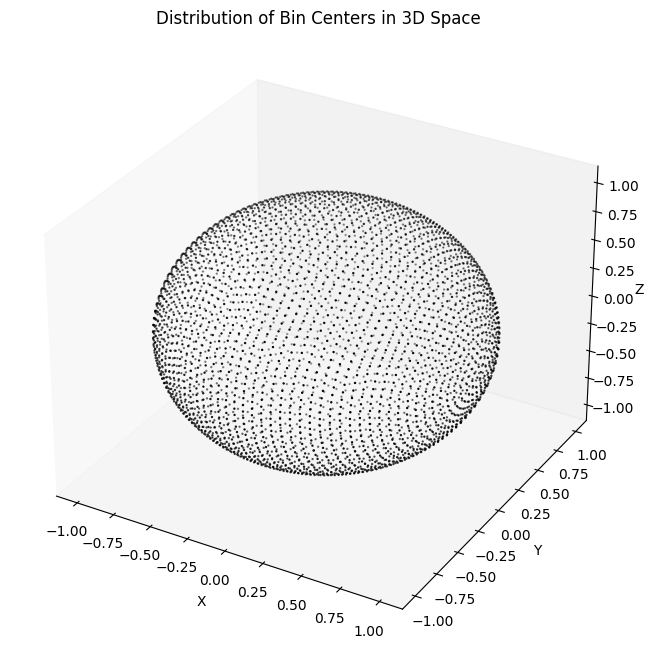

In [49]:
x, y, z = projection_dir_data['bin_centers'] 
print("Number of bin centers:", len(projection_dir_data['bin_centers'][0]))
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor('white')  
ax.patch.set_facecolor('white')   
ax.scatter(x, y, z, marker='o', s=0.5, color='black')  
ax.set_xlabel('X', labelpad=5)
ax.set_ylabel('Y', labelpad=5)
ax.set_zlabel('Z', labelpad=0)  
plt.title('Distribution of Bin Centers in 3D Space')
ax.grid(False)  
plt.show()

### Distributon of S2 coordinates in 3D space

Number of particles: 28982


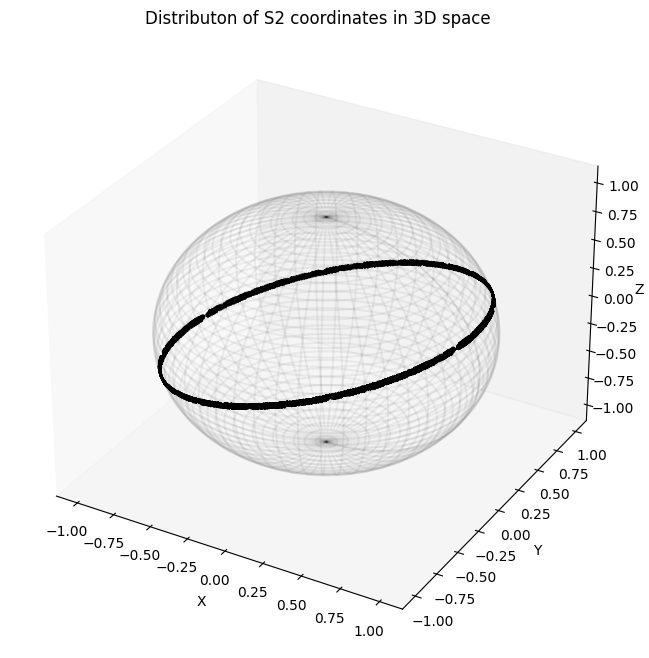

In [50]:
x, y, z = projection_dir_data['pos_full']
print("Number of particles:", len(projection_dir_data['pos_full'][0]))
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor('white')  
ax.patch.set_facecolor('white')
ax.scatter(x, y, z, marker='o', s=0.5, color='black')
ax.set_xlabel('X', labelpad=5)
ax.set_ylabel('Y', labelpad=5)
ax.set_zlabel('Z', labelpad=0)  
plt.title('Distributon of S2 coordinates in 3D space')
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:50j]
xs = np.cos(u)*np.sin(v)
ys = np.sin(u)*np.sin(v)
zs = np.cos(v)
ax.plot_wireframe(xs, ys, zs, color="k", alpha=0.05)
ax.grid(False)  
plt.show()

In [51]:
# Assuming selected_occupancy contains the occupancy data for the selected projection directions
occupancy_full = projection_dir_data['occupancy_full']
thres_ids = projection_dir_data['thres_ids']
selected_occupancy = occupancy_full[thres_ids]

# Indices for the first two, middle two, and last two projection directions
first_two_indices = [0, 1]
middle_two_indices = [len(selected_occupancy)//2 - 1, len(selected_occupancy)//2]
last_two_indices = [-2, -1]

# Print the number of particles for the first two, middle two, and last two projection directions
print("First two projection directions:")
for i in first_two_indices:
    print(f"Projection Direction {thres_ids[i]+1}: {selected_occupancy[i]} particles")

print("\nMiddle two projection directions:")
for i in middle_two_indices:
    print(f"Projection Direction {thres_ids[i]+1}: {selected_occupancy[i]} particles")

print("\nLast two projection directions:")
for i in last_two_indices:
    print(f"Projection Direction {thres_ids[i]+1}: {selected_occupancy[i]} particles")

# Calculate and print the total number of particles in selected projection directions
total_particles_in_selected_directions = selected_occupancy.sum()
print(f"\nTotal number of particles in selected projection directions: {total_particles_in_selected_directions}")

First two projection directions:
Projection Direction 2061: 168 particles
Projection Direction 2062: 378 particles

Middle two projection directions:
Projection Direction 3266: 215 particles
Projection Direction 3318: 226 particles

Last two projection directions:
Projection Direction 3968: 219 particles
Projection Direction 3969: 355 particles

Total number of particles in selected projection directions: 13081


### Step 2C: Understand some of the helper functions

To break down the get_prds() process for step-by-step execution, we can follow these steps. Each step will correspond to a part of the code that contributes to the overall process of generating and organizing projection direction data. 

    Step 1: Initialize Parameters and Load Existing Data: Before calling get_prds(), we ensure that the parameters in params.py are correctly set according to the requirements of the project.

    Step 2: Check for Existing Projection Direction Data: Check if there is existing data to avoid recalculating everything. This step is encapsulated in the load method of _ProjectionDirections.

    Step 3: Parse Alignment Data from .star File: Extract alignment parameters and defocus values from the .star file. This involves reading the file and parsing relevant data.

    Step 4: Augment Data and Calculate S2 Cordinates: Augment the quaternion data to account for symmetry and calculate the S2 coordinates for projection directions.

    Step 5: Bin and Threshold Projection Directions: Organize projection directions into bins and apply thresholding based on occupancy.

    Step 6: Visualize Projection Directions: Visualize the projection directions on a unit sphere.

### (i) Parse alignment data from .star file

The parse_alignment_data() function extracts and returns four key quantities from an alignment parameter file (a .star file).

    1. sh (Shifts): This is a tuple containing two arrays, shx and shy, which represent the shifts in the X and Y directions, respectively, for each particle or image. These shifts are used to align the images correctly, compensating for any translational movement that occurred during image capture.

    2. q (Quaternions): Quaternions are a way to represent rotations in 3D space. This array contains the quaternion representation of the orientation for each particle or image. Quaternions are preferred over Euler angles in many 3D computations because they are not susceptible to gimbal lock and can represent rotations more compactly and robustly.

    3. U and V (Defocus Values): These are arrays containing the defocus values along two principal axes for each particle or image. In the context of electron microscopy, defocus is used intentionally to enhance contrast, but it varies across images. The U and V values represent the major and minor axes of an elliptical approximation of the defocus of the lens, indicating how much the electron beam is defocused when it hits the specimen. These values are crucial for reconstructing the 3D structure from 2D images by compensating for the phase shifts introduced by defocus.

The parse_alignment_data() function processes the alignment file to extract these parameters, which are then used in subsequent steps of image processing and 3D reconstruction workflows. The shifts and defocus values are directly extracted from the .star file, while the quaternions are calculated from the Euler angles (also provided in the .star file) using the eul_to_quat() function, which converts Euler angles to quaternion representation. This conversion is necessary because the alignment data in the .star file is typically given in terms of Euler angles (rlnAngleRot, rlnAngleTilt, rlnAnglePsi), which describe the rotation of each particle or image in 3D space.

In [52]:
def parse_alignment_data():
    sh, q, U, V = get_align_data(p.align_param_file, flip=True)
    print("Alignment data parsed.")
    return sh, q, U, V

sh, q, U, V = parse_alignment_data()
print("The length of x shifts is :" + str(len(list(sh[0]))))
print("The length of y shifts is :" + str(len(list(sh[1]))))
print("The shape of shifts is : [" + str(len(list(sh[0]))) +  ",2]")
print("The shape of quaternion is :" + str(q.shape))
print("Quaternions are as follow:")
print(q)
print("The shape of Defocus Major is :" + str(U.shape))
print("The shape of Defocus Minor is :" + str(V.shape))

Alignment data parsed.
The length of x shifts is :14491
The length of y shifts is :14491
The shape of shifts is : [14491,2]
The shape of quaternion is :(4, 14491)
Quaternions are as follow:
[[ 0.69479793  0.56563591  0.64344695 ...  0.70479876 -0.35389196
   0.65672174]
 [ 0.39835863 -0.34161689  0.43054594 ...  0.70808493 -0.39518709
   0.66572591]
 [-0.43994092 -0.47720151 -0.40205996 ... -0.03489995 -0.59517618
  -0.2592733 ]
 [ 0.40622435 -0.5793381   0.48882922 ... -0.02562085 -0.60361657
  -0.24145999]]
The shape of Defocus Major is :(14491,)
The shape of Defocus Minor is :(14491,)


### (ii) Augment Data and Calculate S2 Cordinates

    1. S2 refers to the 2-dimensional sphere, which is the set of all points in 3-dimensional space that are at a fixed distance (radius) from a central point. Mathematically, S2 can be defined as:

    S2 = {(x, y, z) in R^3 : x^2 + y^2 + z^2 = r^2

    where r is the radius of the sphere, and R^3 denotes the 3-dimensional Euclidean space.

    2. quaternion_to_S2(q) transforms quaternion representations of orientations into points on the unit sphere S2. Quaternions are a way to encode rotation in 3D space, and converting them to points on S2 is a way to visualize or work with these rotations in terms of directional vectors on a sphere. This conversion simplifies dealing with the distribution of orientations or projection directions in 3D space.

In [53]:
def augment_and_calculate_S2_coordinates(q):
    q_augmented = augment(q)
    S2_coords = quaternion_to_S2(q_augmented)
    print("Data augmented and projection directions calculated.")
    return S2_coords
S2_coords = augment_and_calculate_S2_coordinates(q)
print("The shape of S2_coords is :" + str(S2_coords.shape))
print("S2_coords are as follow:")
print(S2_coords)

Data augmented and projection directions calculated.
The shape of S2_coords is :(3, 28982)
S2_coords are as follow:
[[ 0.93498603  0.93566798  0.93833538 ... -0.01291141 -0.05582683
  -0.01904847]
 [ 0.19612808  0.16646047  0.16098962 ... -0.9999031  -0.99822347
  -0.99960161]
 [ 0.29552478  0.31115324  0.30595596 ...  0.00520455  0.02081504
   0.02082725]]


### (iii) Bin and Threshold Projection Directions

The function bin_and_threshold_projection_directions (q_augmented) organizes the augmented quaternion data into bins based on their projection directions and applies thresholds to filter out bins based on the number of orientations they contain. Here's an explanation of the output quantities:

    1. neighb_list: This is a list where each element corresponds to a bin of projection directions. Each element of neighb_list contains the indices of the q_augmented data points that belong to that bin. This list helps in understanding how the orientations are distributed across different bins.

    2. S2: This array represents the coordinates of the projection directions on the unit sphere S2 after mapping the augmented quaternion data. Each column in S2 corresponds to a point on the unit sphere, representing a unique orientation in three-dimensional space.

    3. bin_centers: This array contains the coordinates of the centers of the bins on the unit sphere S2. Each column in bin_centers represents the center of a bin, essentially summarizing the orientation of all the projection directions within that bin. The binning process aims to cover the sphere uniformly, so these centers are distributed to achieve as uniform coverage as possible given the binning strategy.

    4. n_points_in_bin: This array contains the number of points (or orientations) in each bin. It allows for the application of thresholds to filter bins based on their occupancy, ensuring that bins with too few or too many points are handled appropriately (e.g., ignored or further processed).

    5. conjugate_bins: This list contains the indices of bins that have passed the thresholding criteria (i.e., bins that contain a number of points within the specified thres_low and thres_high range). These bins are considered significant and contribute to further analysis, such as identifying distinct projection directions for reconstruction tasks.

In [54]:
def bin_and_threshold_projection_directions(q_augmented):
    bin_width = p.ang_width
    thres_low, thres_high = p.PDsizeThL, p.PDsizeThH
    neighb_list, S2, bin_centers, n_points_in_bin, conjugate_bins = bin_and_threshold(q_augmented, bin_width, 
                                                                                      thres_low, thres_high)
    print("Projection directions binned and thresholded.")
    return neighb_list, S2, bin_centers, n_points_in_bin, conjugate_bins

q_augmented = augment(q)
neighb_list, S2, bin_centers, n_points_in_bin, conjugate_bins = bin_and_threshold_projection_directions(q_augmented)
print("The shape of neighb_list is :" + str(neighb_list.shape))
print("Total number of projection directions across all bins:", str(sum(len(bin) for bin in neighb_list)))
print("The shape of S2 is :" + str(S2.shape))
print("The shape of bin_centers is :" + str(bin_centers.shape))
print("The length of conjugate_bins (Indices of bins that have more than thres_low points and are in the bigger half of the bin list) is :" + str(len(conjugate_bins)))

Projection directions binned and thresholded.
The shape of neighb_list is :(4071,)
Total number of projection directions across all bins: 28982
The shape of S2 is :(3, 28982)
The shape of bin_centers is :(3, 4071)
The length of conjugate_bins (Indices of bins that have more than thres_low points and are in the bigger half of the bin list) is :63


### (iv) Map Clusters to Quaternions

To map which augmented quaternion data points belong to which bin and create a dictionary that represents this mapping, we can use the neighb_list which contains the indices of q_augmented data points for each bin. The keys of this dictionary will be the bin indices, and the values will be lists of indices of q_augmented data points that belong to those bins.

In [55]:
def map_clusters_to_quaternions(q_augmented, neighb_list):
    """
    Maps non-empty clusters to their corresponding quaternion data.
    
    Parameters:
    q_augmented (np.ndarray): The augmented quaternion data array of shape (4, N).
    neighb_list (np.ndarray): An array of arrays, where each sub-array contains the indices of q_augmented data points that belong to a specific bin.
    
    Returns:
    dict: A dictionary where keys are non-empty cluster indices and values are the quaternion data points that belong to those clusters.
    """
    cluster_to_quaternions = {}
    for cluster_index, data_point_indices in enumerate(neighb_list):
        if len(data_point_indices) > 0:  # Exclude empty clusters
            # Retrieve the actual quaternion data points for the current cluster
            quaternions = q_augmented[:, data_point_indices]
            cluster_to_quaternions[cluster_index] = quaternions.T 
    return cluster_to_quaternions

cluster_to_quaternions_mapping = map_clusters_to_quaternions(q_augmented, neighb_list)
print ("There are " + str(len(cluster_to_quaternions_mapping)) + " non-empty clusters out of a total of " + str(neighb_list.shape[0]) + " bins." )

There are 204 non-empty clusters out of a total of 4071 bins.


### (v) Plot S2 clusters onto 3D sphere

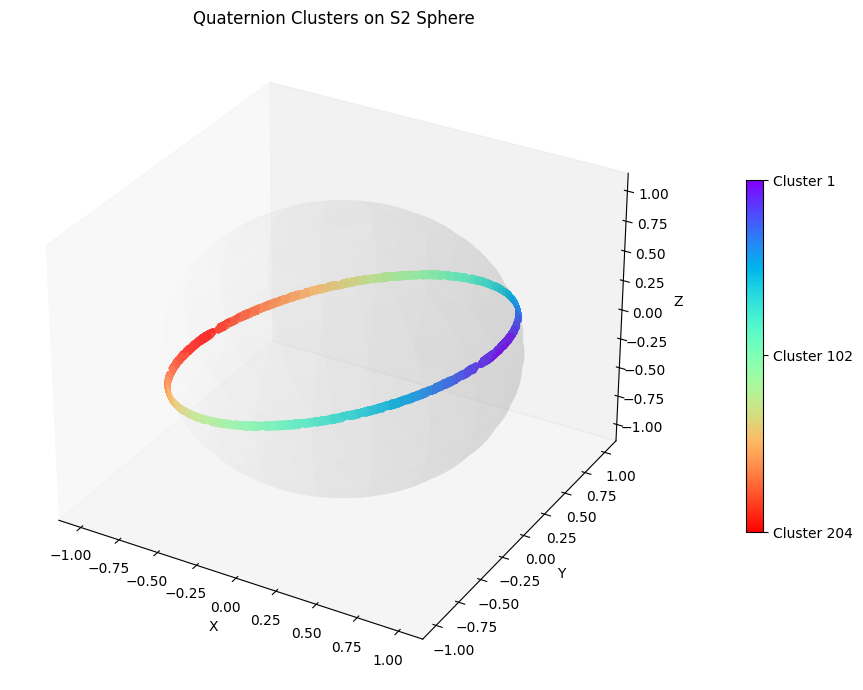

In [56]:
def plot_S2_clusters_on_3D(cluster_to_quaternions_mapping):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d', facecolor='white')
    # Draw a sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, rstride=5, cstride=5, color='white', alpha=0.10, linewidth=0)
    
    # Get the total number of clusters for color mapping
    num_clusters = len(cluster_to_quaternions_mapping)
    colors = cm.rainbow(np.linspace(0, 1, num_clusters))
    
    # Plot each cluster
    cluster_index = 0
    for cluster_id, quaternions in cluster_to_quaternions_mapping.items():
        if quaternions.size == 0:
            continue  # Skip empty clusters
        S2_coords = quaternion_to_S2(quaternions.T)  # Transpose to match expected shape (4, N)
        xs = S2_coords[0, :]
        ys = S2_coords[1, :]
        zs = S2_coords[2, :]
        ax.scatter(xs, ys, zs, color=colors[cluster_index], s=5)
        cluster_index += 1
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Quaternion Clusters on S2 Sphere')
    ax.grid(False)  # Disable the grid
    
    # Colorbar setup
    cbar = fig.colorbar(cm.ScalarMappable(norm=plt.Normalize(vmin=1, vmax=num_clusters), cmap=cm.rainbow),
                        ax=ax, pad=0.1, fraction=0.02)
    
    # Set specific tick positions and labels
    tick_positions = [1, num_clusters // 2, num_clusters]  # Start, middle, end
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels([f'Cluster {tick}' for tick in tick_positions])
    
    cbar.ax.invert_yaxis()  # Optional: Invert color bar axis if needed
    plt.tight_layout()
    plt.show()
    
plot_S2_clusters_on_3D(cluster_to_quaternions_mapping)

There are 63 conjugate clusters out of a total of 4071 bins.


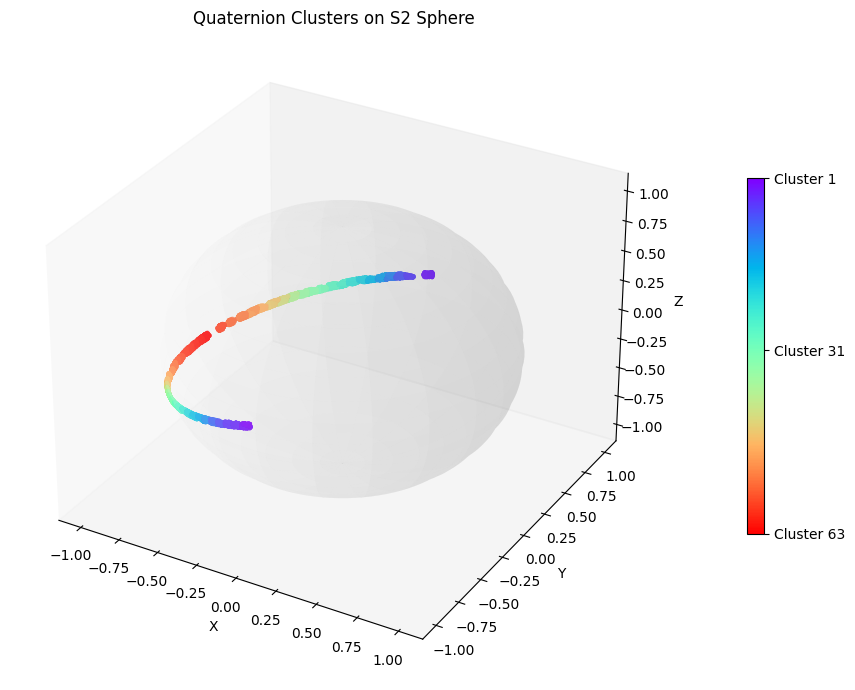

In [57]:
# Conjugate S2 clusters onto 3D sphere
neighb_conjugate_list = []
for i in conjugate_bins:
    neighb_conjugate_list.append(neighb_list[i])
    
cluster_to_quaternions_mapping = map_clusters_to_quaternions(q_augmented, neighb_conjugate_list)
print ("There are " + str(len(cluster_to_quaternions_mapping)) + " conjugate clusters out of a total of " + str(neighb_list.shape[0]) + " bins." )
plot_S2_clusters_on_3D(cluster_to_quaternions_mapping)

The get_distance_CTF_local function is designed to calculate squared Euclidean distances between images (snapshots) that are in similar projection directions, incorporating corrections for the Contrast Transfer Function (CTF) of the microscope. This involves several steps, including image normalization, Fourier transformation, application of the Contrast Transfer Function (CTF), and distance calculation.

    1. Initialization: The function starts by extracting necessary data from the input_data parameter and initializing various arrays for storing processed images, Fourier transforms of images, CTFs, and distances.

    2. Image Processing Loop: For each particle in the given bin (n_particles):

        (a) It determines whether the image comes from the original dataset or its augmented version (conjugates).
        (b) Reads the corresponding image from the file, applying any necessary shifts based on image_offsets. If the image is from the augmented dataset, it is flipped vertically.
        (c) The image is normalized using the background standard deviation and mean.
        (d) The image is then flattened, Fourier transformed, and filtered using a Gaussian filter (G).

    3. Orientation and CTF Calculation:

        (a) The average orientation vector for the bin is calculated from the quaternions.
        (b) The psi angle for in-plane rotation alignment is determined.
        (c) The Contrast Transfer Function (CTF) for each particle is calculated based on its defocus value and other microscope parameters.

    4. Image Averaging and Wiener Filtering: A Wiener filter domain is calculated from the CTFs. Each particle image is Fourier transformed, Wiener filtered, and then averaged to produce a single average image for the bin.

    5. Distance Calculation: Using the Fourier-transformed images and their CTFs, the function calculates squared Euclidean distances between all pairs of images, incorporating CTF correction. This involves Wiener filtering to account for noise and improve accuracy.

    6. Output: The calculated distances, along with other relevant data (e.g., indices, quaternions, CTFs, images), are saved to an output file specified by out_file.

At the end of the get_distance_CTF_local calculations, the saved data includes:

    (a) Distances: A matrix of squared Euclidean distances among the particles within the same bin. These distances take into account the CTF correction, providing a measure of similarity between particles that is adjusted for the imaging conditions of the microscope.

    (b) Indices: The indices of the particles within the bin. These indices refer to the positions of the particles in the original dataset, allowing for easy reference back to the specific particles being analyzed.

    (c) Quaternions (quats): The orientations of the particles represented as quaternions. These orientations are crucial for understanding the relative angles and positions of the particles within their bin.

    (d) CTF: The Contrast Transfer Function for each particle. The CTF matrix contains the CTF values that have been applied to each particle image, which are essential for understanding how the imaging process affects the observed particle images.

    (e) Image Data (imgAll): The processed images of the particles. This might include images that have been filtered, normalized, and aligned based on the average orientation vector and the CTF correction.

    (f) Mask (msk2): If a volumetric mask was used during processing, this data includes the projection of that mask onto the images, which can affect the computed distances by focusing the comparison on specific regions of the particles.

    (g) Average Orientation Vector (PD): The average orientation vector for the particles within the bin, providing a reference direction that summarizes the common orientation of the particles.

    (h) Average Image (imgAvg): The average image computed from the Fourier-transformed images with Wiener filtering applied. This average image represents a consensus view of the particles within the bin, adjusted for the effects of the CTF.

### The annularMask function

The annularMask function generates an annular (donut-shaped) mask of a specified inner radius a and outer radius b for an N x M matrix. This mask is used in image processing tasks, particularly in fields like cryo-electron microscopy, to focus analyses or operations on specific regions of an image while ignoring others. The mask consists of values set to 1 for pixels within the specified annular region and 0 for pixels outside this region, effectively creating a "donut" shape centered on the pixel located at (N/2, M/2).

    1. It initializes a zero matrix of size N x M.
    2. It iterates through each pixel in the matrix, calculating the distance of each pixel from the center (N/2, M/2).
    3. If the squared distance of a pixel from the center is within the range defined by the squared inner radius aSq and the squared outer radius bSq, the function sets that pixel value to 1, indicating it is within the annular region.
    4. Pixels outside this range are left as 0, indicating they are outside the annular region.

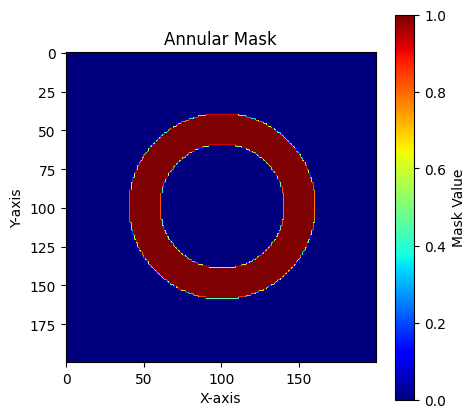

In [58]:
# Define parameters for the annular mask
a = 40   # Inner radius
b = 60   # Outer radius
N = 200  # Number of rows
M = 200  # Number of columns
# Generate the annular mask
mask = annularMask(a, b, N, M)
# Plot the annular mask
plt.figure(figsize=(5,5))
plt.imshow(mask, cmap='jet')
plt.title('Annular Mask')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(label='Mask Value')
plt.show()

### The quats_to_unit_vecs function 

The quats_to_unit_vecs function converts a set of quaternions to unit vectors representing average projection directions. Quaternions are a way to represent rotations in three-dimensional space, and this function maps them to points on the unit sphere, effectively translating rotational information into directional vectors.

    1. The input q is expected to be an array of quaternions, where each quaternion is represented by four components (q[0,:], q[1,:], q[2,:], q[3,:]) and is stored in columns of the array.
    2. The function calculates the corresponding unit vectors for these quaternions using the formula provided. This formula maps the quaternion representation of rotations to points on the unit sphere in 3D space.
    3. The output is an array of unit vectors (PDs), where each vector is a point on the unit sphere representing the direction of the corresponding quaternion.

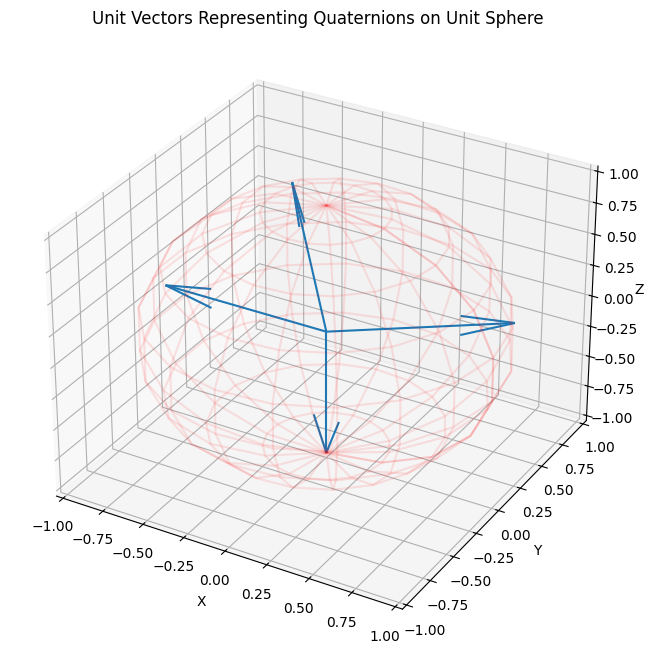

In [59]:
# Example quaternions (4 components each, stored in columns)
q = np.array([[0.7071, 0.7071, 0, 0],  # Quaternion 1
              [0, 0, 0.7071, 0.7071],  # Quaternion 2
              [0.5, 0.5, 0.5, 0.5],    # Quaternion 3
              [0.7071, 0, 0.7071, 0]]) # Quaternion 4
# Convert quaternions to unit vectors
PDs = quats_to_unit_vecs(q)
# Plot the unit vectors on a unit sphere
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, PDs[0, :], PDs[1, :], PDs[2, :], length=1.0, normalize=True)
# Draw a unit sphere for reference
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X', labelpad=5)
ax.set_ylabel('Y', labelpad=5)
ax.set_zlabel('Z', labelpad=0) 
plt.title('Unit Vectors Representing Quaternions on Unit Sphere')
plt.show()

### Step 3: Distance calculation

### Step 3A: Set filter parameters

In [60]:
filter_params = FilterParams(method='Butter', cutoff_freq=0.5, order=8)
print("Filter parameters:", filter_params)

Filter parameters: FilterParams(method='Butter', cutoff_freq=0.5, order=8)


### Step 3B: Data acquisition  

Let us take the case of a single projection direction cluster (prD0) out of the 63 projection directions 

In [61]:
input_data = _construct_input_data(prds.thresholded_image_indices, 
                                   prds.quats_full, prds.defocus)
sample_data = input_data[0]
if hasattr(sample_data, '__dict__'):
    # If the instance has a __dict__ attribute, print its keys
    print(vars(sample_data).keys())
elif isinstance(sample_data, dict):
    # If the instance itself is a dictionary
    print(sample_data.keys())
else:
    # If LocalInput uses a method to return its attributes as a dictionary
    # Assuming the method is named 'to_dict()'
    print(sample_data.to_dict().keys())

dict_keys(['indices', 'quats', 'defocus', 'dist_file'])


In [62]:
def print_list_summary(lst, lst_name):
    if len(lst) > 6:
        summary_str = ', '.join(map(str, lst[:3])) + ', ..., ' + ', '.join(map(str, lst[-3:]))
        print(lst_name + " :", summary_str)
    else:
        print(lst_name + " :", ', '.join(map(str, lst)))

indices_list = list(sample_data.indices) if hasattr(sample_data, 'indices') else []
quats_list = list(sample_data.quats) if hasattr(sample_data, 'quats') else []
defocus_list = list(sample_data.defocus) if hasattr(sample_data, 'defocus') else []
dist_file_list = [sample_data.dist_file] if hasattr(sample_data, 'dist_file') else []
print("The length of the indices_list is:", len(indices_list))
#print_list_summary(indices_list, lst_name="indices_list")
print("The length of the quats_list is:", len(quats_list[0]))
print("The length of the defocus_list is:", len(defocus_list))
print("The output is saved as:", dist_file_list)

The length of the indices_list is: 168
The length of the quats_list is: 168
The length of the defocus_list is: 168
The output is saved as: ['output/sample/distances/IMGs_prD_0']


### Step 3C: Distance calculation   

In [63]:
get_distance_CTF_local(
    input_data=sample_data,
    filter_params=filter_params,
    img_file_name=p.img_stack_file,
    image_offsets=prds.microscope_origin,
    n_particles_tot=len(prds.defocus),
    relion_data=p.relion_data
)

### Step 4: Post distance calculation analysis

In [64]:
dist_file_path = sample_data.dist_file
with open(dist_file_path, 'rb') as file:
    dist_data = pickle.load(file)
print(dist_data.keys())

dict_keys(['D', 'ind', 'q', 'CTF', 'imgAll', 'msk2', 'PD', 'imgAvg'])


#### Visualizing the distance matrix

The shape of the distance matrix is (168, 168)


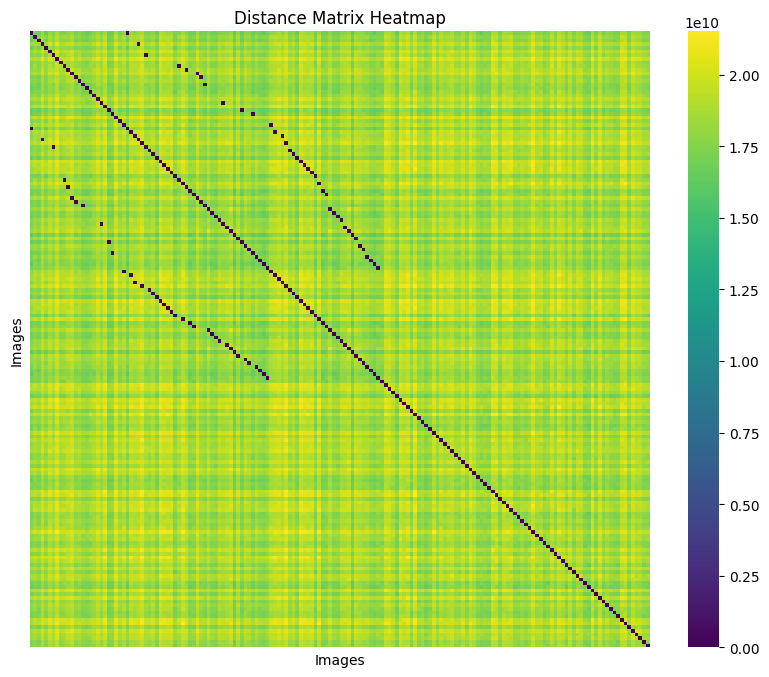

In [65]:
distance_matrix = dist_data['D']
# Heatmap
print("The shape of the distance matrix is", distance_matrix.shape)
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Distance Matrix Heatmap')
plt.xlabel('Images')
plt.ylabel('Images')
plt.show()

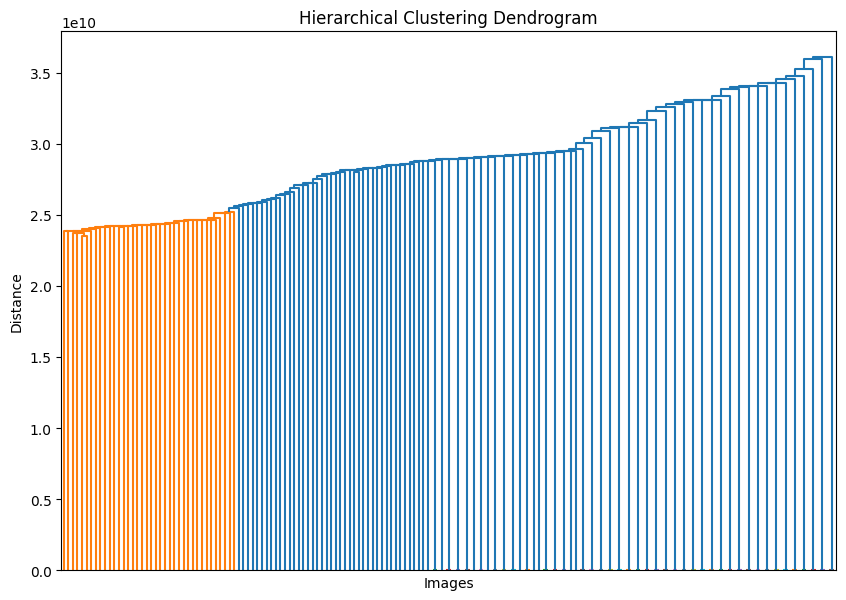

In [66]:
# Hierarchical Clustering Dendrogram
linked = linkage(distance_matrix, 'single')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, no_labels=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Images')
plt.ylabel('Distance')
plt.show()

#### Visualizing the images

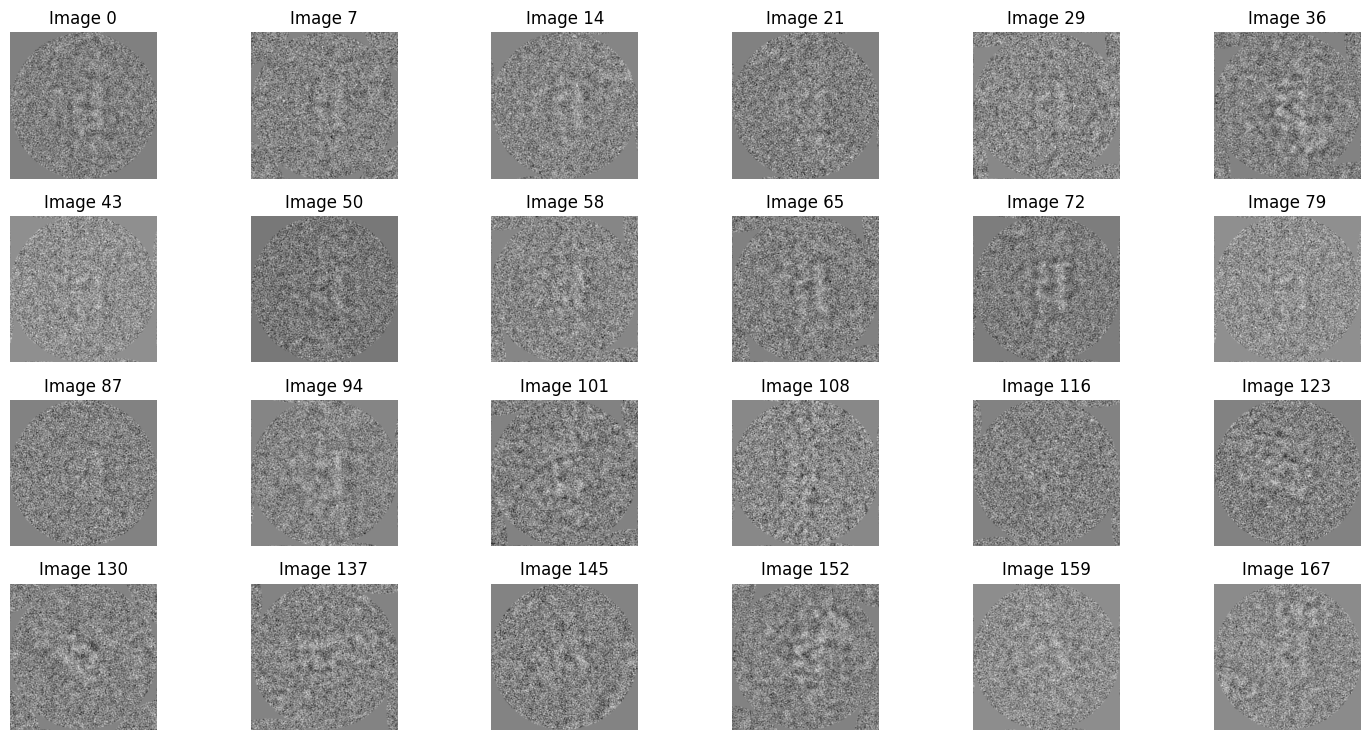

In [67]:
imgAll = dist_data['imgAll']
num_images_to_display = 24
num_rows = 4
num_cols = 6
# Generate evenly spaced indices to select images across the dataset
image_indices = np.linspace(0, len(imgAll) - 1, num_images_to_display, dtype=int)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7.5))
axes_flat = axes.flatten()
# Loop through the selected images and plot
for ax, idx in zip(axes_flat, image_indices):
    ax.imshow(imgAll[idx], cmap='gray')
    ax.axis('off')  # Hide axes ticks
    ax.set_title(f'Image {idx}')
plt.tight_layout()
plt.show()

#### Visualizing the average image for the projection direction

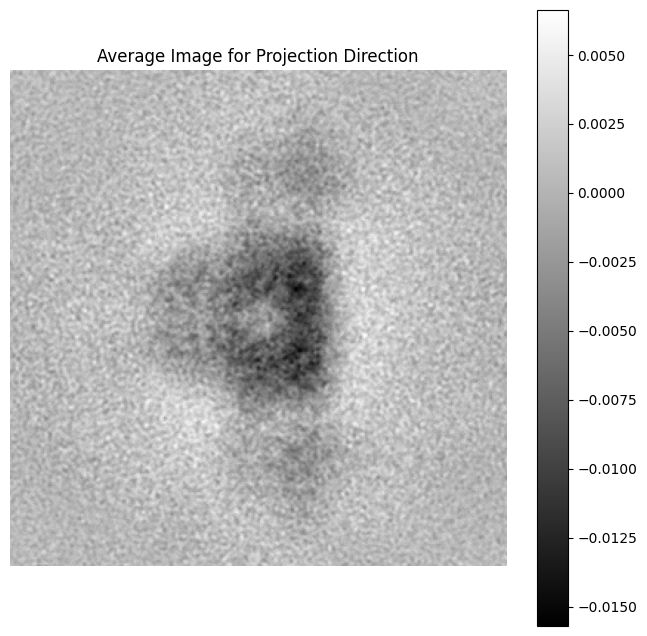

In [68]:
imgAvg = dist_data['imgAvg']
plt.figure(figsize=(8, 8))
plt.imshow(imgAvg, cmap='gray')
plt.colorbar()
plt.title('Average Image for Projection Direction')
plt.axis('off') 
plt.show()